# TRABALHO DE CONCLUSÃO DE CURSO EM CIÊNCIA DE DADOS - PUC MINAS

Aluno: GLEYSON NORONHA DE SOUSA

## Previsão do tempo de atendimento de chamados na Central de Serviços da Receita Federal

___________________________________________________________________________________________________

### 1. CONFIGURAÇÕES INICIAIS

#### 1.1 Instalação de bibliotecas

In [3]:
# pip install pycaret #instalação da biblioteca Pycaret para simulação de regressão

#### 1.2 Importação de bibliotecas

In [4]:
# biblioteca para manipulação dados
import numpy as np
import pandas as pd
import sklearn.metrics as sklm


# biblioteca para gráficos
import matplotlib.pyplot as plt
import seaborn as sns

# biblioteca para acesso a banco de dados
import sqlite3


# setando padrões nas bibliotecas de saída
np.set_printoptions(threshold=None, precision=2)
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)


In [5]:
# Bliblioteca Pycaret de Regressão
import pycaret.regression as pycr

### 2. COLETA DE DADOS

In [6]:
#Criando conexão com o Banco de ddados
conexaoBD = sqlite3.connect('D:\SQL Lite no installer\DB Browser for SQLite\PosGraduacao.db')



In [7]:
#Carregando a base chamados e de encaminhados  a partir de um select completo na base de dados.
df_chamados = pd.read_sql('select * from chamados', con = conexaoBD)
df_encaminhamentos = pd.read_sql('select * from encaminhamentos', con = conexaoBD)

In [8]:
#Carregando resumo da base de encaminhamentos
df_encaminha_resumo = pd.read_sql ('SELECT B.NUMERO_TICKET, B.QTDE_ENCAMINHA, B.GRUPO_DE FROM CHAMADOS A LEFT JOIN (SELECT NUMERO_TICKET, COUNT(*) AS QTDE_ENCAMINHA, min(DTHORA_CONVERTIDA), GRUPO_DE FROM (SELECT NUMERO_TICKET, strftime("'"%Y-%m-%d %H:%M:%S"'",substr(DATA_HORA, 7,4)||"'"-"'"||substr(DATA_HORA, 4,2)||"'"-"'"||substr(DATA_HORA, 1,2)||"'" "'" ||substr(DATA_HORA, 12,8)) DTHORA_CONVERTIDA, GRUPO_DE FROM ENCAMINHAMENTOS WHERE GRUPO_DE IS NOT NULL ) GROUP BY NUMERO_TICKET) AS B ON A.NUMERO_TICKET = B.NUMERO_TICKET WHERE B.NUMERO_TICKET IS NOT NULL UNION SELECT a.NUMERO_TICKET, 0 as QTDE_ENCAMINHA, "'"NAO INFORMADO"'" AS GRUPO_DE FROM CHAMADOS A LEFT JOIN (SELECT NUMERO_TICKET, COUNT(*) AS QTDE_ENCAMINHA, min(DTHORA_CONVERTIDA), GRUPO_DE FROM (SELECT NUMERO_TICKET, strftime("'"%Y-%m-%d %H:%M:%S"'",substr(DATA_HORA, 7,4)||"'"-"'"||substr(DATA_HORA, 4,2)||"'"-"'"||substr(DATA_HORA, 1,2)||"'" "'" ||substr(DATA_HORA, 12,8)) DTHORA_CONVERTIDA, GRUPO_DE FROM ENCAMINHAMENTOS WHERE GRUPO_DE IS NOT NULL ) GROUP BY NUMERO_TICKET) AS B ON A.NUMERO_TICKET = B.NUMERO_TICKET WHERE B.NUMERO_TICKET IS NULL',con = conexaoBD)

In [9]:
#Impressão das primeiras colunas da base de dados
df_chamados.head()

,ACIONAMENTO,ACIONAMENTO_VIA,AGUARDANDO_USUARIO,ARF,CATEGORIA,CHAMADO_REABERTO,CLIENTE,CPF,CRIADO_POR,DATA_CONCLUIDO,DATA_EMISSAO,DATA_HORA_FIM_ATEND,DATA_HORA_INICIO_ATEND,DATA_RESOLVIDO,DATA_STATUS,DESCRICAO_DEMANDA,DESCRICAO_TKT_VINCULADO,GRUPO_CRIACAO,GRUPO_GESTOR,MUNICIPIO_ATENDIMENTO,NIVEL_SEVERIDADE_INFRA,NOME,NR_TICKET_VINCULADO,NUMERO_TICKET,OBSERVACAO,OC_RF,REDE_ASSISTIDA,RESPONSAVEL_PELO_ATENDIMENTO,SERVICO,SETOR,SOLUCAO_APLICADA,SITUACAO,STATUS,SUB_CATEGORIA,TEMPO_CONSUMIDO,TEMPO_DE_REACAO,TEMPO_PREVISTO_MINUTOS,TIPO_RECURSO,TIPO_TICKET,TIPO_TICKET_VINCULADO,TIPO_USUARIO,UA,UF,UG_ATENDIMENTO,UG_SERVICO,UNIDADE,AGUARDANDOPRESTADOR,EMAIL
0,2019SS/0000396318,INTERNET,Sim,None,NECESSIDADE DE GERAR DEMANDA,Não,RFB,69563187091.0,69563187091.0,25/04/2022 08:59:20,09/05/2019 10:35:17,None,09/05/2019 10:52:30,18/04/2022 08:59:09,25/04/2022 08:59:20,Ocorrem travamentos durante o atendimento impe...,None,None,UNACDFEFAU,RIO GRANDE,Baixa,Catia Simone Cardoso Sodre,None,2019SS/0000396318,None,10ª RF,Sim,37295853120,"CENTRAL DE SERVIÇOS RFB,NECESSIDADE DE GERAR D...",None,o Sistema de encontra normal.,Fechado,Fechado,None,292.0,8,4320,06747,Requisição de Serviço,None,Externo,1017700.0,RS,SUNAC,SUNEF,ALF-PORTO DE RIO GRANDE,N,catia.sodre@receita.fazenda.gov.br
1,2022SS/0000242878,INTERNET,Sim,None,ATENDIMENTO REMOTO A ESTAÇÕES DE TRABALHO/NOTE...,Não,RFB,48464252072.0,28676497818.0,11/04/2022 09:49:07,05/04/2022 10:08:54,None,05/04/2022 10:13:53,07/04/2022 09:03:53,11/04/2022 09:49:07,Erro ao tentar efetuar as atualizações do Wind...,None,None,GSOPBRARLARF10SR,RIO GRANDE,Baixa,ALESSANDRO ALMADA DA COSTA,None,2022SS/0000242878,None,10ª RF,Sim,28676497818,"ATENDIMENTO REMOTO,ATENDIMENTO REMOTO A ESTAÇÕ...",None,Executado sfc /scannow q encontrou erros e cor...,Fechado,Fechado,None,71.0,3,240,None,Requisição de Serviço,None,Externo,1017700.0,RS,SUPOP,SUPOP,ALF-PORTO DE RIO GRANDE,N,alessandro.costa@receita.fazenda.gov.br
2,2022SS/0000243418,INTRANET,Não,None,MANUTENCAO DO SERVIDOR,Sim,SERPRO,94907285000.0,94907285000.0,11/04/2022 09:44:07,05/04/2022 11:27:34,None,05/04/2022 11:30:10,06/04/2022 09:39:51,11/04/2022 09:44:07,Prezados solicito que os seguintes procediment...,None,None,GSOPDFARLRFBUCLR,RIO GRANDE,Baixa,Fabiano Teixeira Gauterio,None,2022SS/0000243418,None,10ª RF,Sim,58849319053,"RFB - ADMINISTRAÇÃO NACIONAL DE AMBIENTES,ANA ...",None,Baixado o instalador do Zabbix e executados os...,Fechado,Fechado,None,104.0,2,720,None,Requisição de Serviço,None,Interno,1017700.0,RS,SUPOP,SUPOP,ALF-PORTO DE RIO GRANDE,N,fabiano.gauterio@serpro.gov.br
3,2022SS/0000253561,INTERNET,Não,None,INSTALAÇÃO OU CONFIGURAÇÃO PRESENCIAL DE ESTAÇ...,Não,RFB,62038524068.0,62038524068.0,13/04/2022 11:29:10,08/04/2022 09:11:22,None,08/04/2022 09:23:34,08/04/2022 11:26:30,13/04/2022 11:29:10,Registro SOLICORP: 0000045461 Preparação estaç...,None,None,GSOPRSARLAALFRGE,None,Baixa,VALESCA EDOM NUNES,None,2022SS/0000253561,None,10ª RF,Sim,28676497818,"ATENDIMENTO PRESENCIAL, ARL 3,58",None,Foi efetuada a formatação e instalação da esta...,Fechado,Fechado,None,133.0,9,1200,None,Requisição de Serviço,None,Externo,1017700.0,None,SUPOP,SUPOP,ALF-PORTO DE RIO GRANDE,N,valesca.nunes@rfb.gov.br
4,2022SS/0000255589,INTRANET,Não,None,ATENDIMENTO REMOTO A ESTAÇÕES DE TRABALHO/NOTE...,Não,SERPRO,55804993020.0,28676497818.0,13/04/2022 15:44:11,08/04/2022 15:25:11,None,08/04/2022 15:27:49,08/04/2022 15:40:36,13/04/2022 15:44:11,Efetuar atualização para a versão 21H2 do wind...,None,None,GSOPBRARLARF10SR,RIO GRANDE,Baixa,NORY CELESTE SAIS DE FERREIRA,None,2022SS/0000255589,None,10ª RF,Sim,28676497818,"ATENDIMENTO REMOTO,ATENDIMENTO REMOTO A ESTAÇÕ...",None,Efetuada a atualização com sucesso. Foi aprove...,Fechado,Fechado,None,13.0,0,720,None,Requisição de Serviço,None,Externo,1017700.0,RS,SUPOP,SUPOP,ALF-PORTO DE RIO GRANDE,N,nory.s.ferreira@rfb.gov.br


In [10]:
#Descrição de informações da base de chamados. Impressão das dimensões.

print("\nDimensões de Chamados:\n{0}\n".format(df_chamados.shape))



Dimensões de Chamados:
(14013, 48)



In [11]:
#Descrição de informações da base de Encaminhamentos. Impressão das dimensões.

print("\nDimensões de Encaminhamentos:\n{0}\n".format(df_encaminhamentos.shape))



Dimensões de Encaminhamentos:
(97915, 6)



In [12]:
#Descrição de informações da base carregada. Impressão do campos.
print("\nCampos de Chamados:\n{0}\n".format(list(df_chamados.keys())))



Campos de Chamados:
['ACIONAMENTO', 'ACIONAMENTO_VIA', 'AGUARDANDO_USUARIO', 'ARF', 'CATEGORIA', 'CHAMADO_REABERTO', 'CLIENTE', 'CPF', 'CRIADO_POR', 'DATA_CONCLUIDO', 'DATA_EMISSAO', 'DATA_HORA_FIM_ATEND', 'DATA_HORA_INICIO_ATEND', 'DATA_RESOLVIDO', 'DATA_STATUS', 'DESCRICAO_DEMANDA', 'DESCRICAO_TKT_VINCULADO', 'GRUPO_CRIACAO', 'GRUPO_GESTOR', 'MUNICIPIO_ATENDIMENTO', 'NIVEL_SEVERIDADE_INFRA', 'NOME', 'NR_TICKET_VINCULADO', 'NUMERO_TICKET', 'OBSERVACAO', 'OC_RF', 'REDE_ASSISTIDA', 'RESPONSAVEL_PELO_ATENDIMENTO', 'SERVICO', 'SETOR', 'SOLUCAO_APLICADA', 'SITUACAO', 'STATUS', 'SUB_CATEGORIA', 'TEMPO_CONSUMIDO', 'TEMPO_DE_REACAO', 'TEMPO_PREVISTO_MINUTOS', 'TIPO_RECURSO', 'TIPO_TICKET', 'TIPO_TICKET_VINCULADO', 'TIPO_USUARIO', 'UA', 'UF', 'UG_ATENDIMENTO', 'UG_SERVICO', 'UNIDADE', 'AGUARDANDOPRESTADOR', 'EMAIL']



In [13]:
#Descrição de informações da base carregada. Impressão dos tipos de dados.
print("\nTipos dos dados de chamados:\n{0}\n".format(df_chamados.dtypes))


Tipos dos dados de chamados:
ACIONAMENTO                      object
ACIONAMENTO_VIA                  object
AGUARDANDO_USUARIO               object
ARF                              object
CATEGORIA                        object
CHAMADO_REABERTO                 object
CLIENTE                          object
CPF                              object
CRIADO_POR                       object
DATA_CONCLUIDO                   object
DATA_EMISSAO                     object
DATA_HORA_FIM_ATEND              object
DATA_HORA_INICIO_ATEND           object
DATA_RESOLVIDO                   object
DATA_STATUS                      object
DESCRICAO_DEMANDA                object
DESCRICAO_TKT_VINCULADO          object
GRUPO_CRIACAO                    object
GRUPO_GESTOR                     object
MUNICIPIO_ATENDIMENTO            object
NIVEL_SEVERIDADE_INFRA           object
NOME                             object
NR_TICKET_VINCULADO              object
NUMERO_TICKET                    object
OBSERVACAO

In [14]:
# Criar estatisticas descritiva dos campos numéricos:

print(df_chamados.describe())



       TEMPO_CONSUMIDO  TEMPO_DE_REACAO  TEMPO_PREVISTO_MINUTOS            UA
count     14008.000000     14013.000000            14013.000000  1.034300e+04
mean        361.720303       416.280525              708.170128  6.024406e+05
std        6105.326957      6064.241822             2278.660418  2.842916e+05
min           0.000000         0.000000                0.000000  1.010000e+04
25%           3.000000         0.000000              240.000000  4.101000e+05
50%          29.000000         6.000000              240.000000  7.001000e+05
75%          86.000000        28.000000              360.000000  8.169000e+05
max      397914.000000    469576.000000           114880.000000  1.017801e+06


In [15]:
#Descrição de informações da base de chamados. Impressão das dimensões.

print("\nDimensões Resumo de encaminhamentos:\n{0}\n".format(df_encaminha_resumo.shape))


Dimensões Resumo de encaminhamentos:
(14013, 3)



In [16]:
df_encaminha_resumo.head()

,NUMERO_TICKET,QTDE_ENCAMINHA,GRUPO_DE
0,2019SS/0000350741,10,ATGSSPRFB
1,2019SS/0000396318,16,ATGSSPRFB
2,2019SS/0000401230,12,ATGSSPRFB
3,2019SS/0000417381,17,ATGSSPRFB
4,2019SS/0000633518,7,ATGSSPRFB


In [17]:
# Criar estatisticas descritiva dos campos numéricos:

print(df_encaminha_resumo.describe())


       QTDE_ENCAMINHA
count    14013.000000
mean         3.395204
std          4.852546
min          0.000000
25%          2.000000
50%          3.000000
75%          4.000000
max        332.000000


In [18]:
#Descrição de informações da base carregada. Impressão dos tipos de dados.
print("\nTipos dos dados de resumo de encaminhamentos:\n{0}\n".format(df_encaminha_resumo.dtypes))


Tipos dos dados de resumo de encaminhamentos:
NUMERO_TICKET     object
QTDE_ENCAMINHA     int64
GRUPO_DE          object
dtype: object



### 2. 1 JUNÇÃO DAS BASES DE DADOS

In [19]:
#Junção dos Datasets Chamados (df_chamados) e Resumo de Encaminhamento de chamados (df_encaminha_resumo)
df_completo = pd.merge(df_chamados, df_encaminha_resumo, on='NUMERO_TICKET')

In [20]:
df_completo.head()

,ACIONAMENTO,ACIONAMENTO_VIA,AGUARDANDO_USUARIO,ARF,CATEGORIA,CHAMADO_REABERTO,CLIENTE,CPF,CRIADO_POR,DATA_CONCLUIDO,DATA_EMISSAO,DATA_HORA_FIM_ATEND,DATA_HORA_INICIO_ATEND,DATA_RESOLVIDO,DATA_STATUS,DESCRICAO_DEMANDA,DESCRICAO_TKT_VINCULADO,GRUPO_CRIACAO,GRUPO_GESTOR,MUNICIPIO_ATENDIMENTO,NIVEL_SEVERIDADE_INFRA,NOME,NR_TICKET_VINCULADO,NUMERO_TICKET,OBSERVACAO,OC_RF,REDE_ASSISTIDA,RESPONSAVEL_PELO_ATENDIMENTO,SERVICO,SETOR,SOLUCAO_APLICADA,SITUACAO,STATUS,SUB_CATEGORIA,TEMPO_CONSUMIDO,TEMPO_DE_REACAO,TEMPO_PREVISTO_MINUTOS,TIPO_RECURSO,TIPO_TICKET,TIPO_TICKET_VINCULADO,TIPO_USUARIO,UA,UF,UG_ATENDIMENTO,UG_SERVICO,UNIDADE,AGUARDANDOPRESTADOR,EMAIL,QTDE_ENCAMINHA,GRUPO_DE
0,2019SS/0000396318,INTERNET,Sim,None,NECESSIDADE DE GERAR DEMANDA,Não,RFB,69563187091.0,69563187091.0,25/04/2022 08:59:20,09/05/2019 10:35:17,None,09/05/2019 10:52:30,18/04/2022 08:59:09,25/04/2022 08:59:20,Ocorrem travamentos durante o atendimento impe...,None,None,UNACDFEFAU,RIO GRANDE,Baixa,Catia Simone Cardoso Sodre,None,2019SS/0000396318,None,10ª RF,Sim,37295853120,"CENTRAL DE SERVIÇOS RFB,NECESSIDADE DE GERAR D...",None,o Sistema de encontra normal.,Fechado,Fechado,None,292.0,8,4320,06747,Requisição de Serviço,None,Externo,1017700.0,RS,SUNAC,SUNEF,ALF-PORTO DE RIO GRANDE,N,catia.sodre@receita.fazenda.gov.br,16,ATGSSPRFB
1,2022SS/0000242878,INTERNET,Sim,None,ATENDIMENTO REMOTO A ESTAÇÕES DE TRABALHO/NOTE...,Não,RFB,48464252072.0,28676497818.0,11/04/2022 09:49:07,05/04/2022 10:08:54,None,05/04/2022 10:13:53,07/04/2022 09:03:53,11/04/2022 09:49:07,Erro ao tentar efetuar as atualizações do Wind...,None,None,GSOPBRARLARF10SR,RIO GRANDE,Baixa,ALESSANDRO ALMADA DA COSTA,None,2022SS/0000242878,None,10ª RF,Sim,28676497818,"ATENDIMENTO REMOTO,ATENDIMENTO REMOTO A ESTAÇÕ...",None,Executado sfc /scannow q encontrou erros e cor...,Fechado,Fechado,None,71.0,3,240,None,Requisição de Serviço,None,Externo,1017700.0,RS,SUPOP,SUPOP,ALF-PORTO DE RIO GRANDE,N,alessandro.costa@receita.fazenda.gov.br,5,GSOPBRARLARF10SR
2,2022SS/0000243418,INTRANET,Não,None,MANUTENCAO DO SERVIDOR,Sim,SERPRO,94907285000.0,94907285000.0,11/04/2022 09:44:07,05/04/2022 11:27:34,None,05/04/2022 11:30:10,06/04/2022 09:39:51,11/04/2022 09:44:07,Prezados solicito que os seguintes procediment...,None,None,GSOPDFARLRFBUCLR,RIO GRANDE,Baixa,Fabiano Teixeira Gauterio,None,2022SS/0000243418,None,10ª RF,Sim,58849319053,"RFB - ADMINISTRAÇÃO NACIONAL DE AMBIENTES,ANA ...",None,Baixado o instalador do Zabbix e executados os...,Fechado,Fechado,None,104.0,2,720,None,Requisição de Serviço,None,Interno,1017700.0,RS,SUPOP,SUPOP,ALF-PORTO DE RIO GRANDE,N,fabiano.gauterio@serpro.gov.br,5,GSOPDFARLRFBUCLR
3,2022SS/0000253561,INTERNET,Não,None,INSTALAÇÃO OU CONFIGURAÇÃO PRESENCIAL DE ESTAÇ...,Não,RFB,62038524068.0,62038524068.0,13/04/2022 11:29:10,08/04/2022 09:11:22,None,08/04/2022 09:23:34,08/04/2022 11:26:30,13/04/2022 11:29:10,Registro SOLICORP: 0000045461 Preparação estaç...,None,None,GSOPRSARLAALFRGE,None,Baixa,VALESCA EDOM NUNES,None,2022SS/0000253561,None,10ª RF,Sim,28676497818,"ATENDIMENTO PRESENCIAL, ARL 3,58",None,Foi efetuada a formatação e instalação da esta...,Fechado,Fechado,None,133.0,9,1200,None,Requisição de Serviço,None,Externo,1017700.0,None,SUPOP,SUPOP,ALF-PORTO DE RIO GRANDE,N,valesca.nunes@rfb.gov.br,11,GSOPRSARLAALFRGE
4,2022SS/0000255589,INTRANET,Não,None,ATENDIMENTO REMOTO A ESTAÇÕES DE TRABALHO/NOTE...,Não,SERPRO,55804993020.0,28676497818.0,13/04/2022 15:44:11,08/04/2022 15:25:11,None,08/04/2022 15:27:49,08/04/2022 15:40:36,13/04/2022 15:44:11,Efetuar atualização para a versão 21H2 do wind...,None,None,GSOPBRARLARF10SR,RIO GRANDE,Baixa,NORY CELESTE SAIS DE FERREIRA,None,2022SS/0000255589,None,10ª RF,Sim,28676497818,"ATENDIMENTO REMOTO,ATENDIMENTO REMOTO A ESTAÇÕ...",None,Efetuada a atualização com sucesso. Foi aprove...,Fechado,Fechado,None,13.0,0,720,None,Requisição de Serviço,None,Externo,1017700.0,RS,SUPOP,SUPOP,ALF-PORTO DE RIO GRANDE,N,nory.s.ferreira@rfb.gov.br,2,GSOPBRARLARF10SR


In [21]:
#Descrição de informações da base de chamados. Impressão das dimensões.

print("\nDimensões Resumo de encaminhamentos:\n{0}\n".format(df_completo.shape))


Dimensões Resumo de encaminhamentos:
(14013, 50)



In [22]:
# observa novamente a estatistica descritiva dos campos numéricos, agora na base completa:

print(df_completo.describe())

       TEMPO_CONSUMIDO  TEMPO_DE_REACAO  TEMPO_PREVISTO_MINUTOS            UA  \
count     14008.000000     14013.000000            14013.000000  1.034300e+04   
mean        361.720303       416.280525              708.170128  6.024406e+05   
std        6105.326957      6064.241822             2278.660418  2.842916e+05   
min           0.000000         0.000000                0.000000  1.010000e+04   
25%           3.000000         0.000000              240.000000  4.101000e+05   
50%          29.000000         6.000000              240.000000  7.001000e+05   
75%          86.000000        28.000000              360.000000  8.169000e+05   
max      397914.000000    469576.000000           114880.000000  1.017801e+06   

       QTDE_ENCAMINHA  
count    14013.000000  
mean         3.395204  
std          4.852546  
min          0.000000  
25%          2.000000  
50%          3.000000  
75%          4.000000  
max        332.000000  


## 3. TRATAMENTO E ANÁLISE EXPLORATÓRIA DOS DADOS

### Explorar os dias da semana que os chamados são abertos e a hora de abertura
* Uma caracteristica empírica de comportamento é a maneira que os usuários se comportam  ao longo do dia. O mesmo também pode ocorrer ao longo dos dias da semana. Assim, é salutar avaliar qual o comportamento da abertura dos chamados.

* Assim, pretende-se extrair o dia da semana e a hora abertura do chamado e criar dois novos atributos com estas informações.



### 3.1 Tratamento campos data

In [23]:
from datetime import date

# Converte a data_emissao para Date

df_completo["DATA_EMISSAO"] = pd.to_datetime(df_chamados["DATA_EMISSAO"], dayfirst=True)
print("\nTipos dos dados de chamados:\n{0}\n".format(df_completo["DATA_EMISSAO"].dtypes))




Tipos dos dados de chamados:
datetime64[ns]



In [24]:
df_completo.head()


,ACIONAMENTO,ACIONAMENTO_VIA,AGUARDANDO_USUARIO,ARF,CATEGORIA,CHAMADO_REABERTO,CLIENTE,CPF,CRIADO_POR,DATA_CONCLUIDO,DATA_EMISSAO,DATA_HORA_FIM_ATEND,DATA_HORA_INICIO_ATEND,DATA_RESOLVIDO,DATA_STATUS,DESCRICAO_DEMANDA,DESCRICAO_TKT_VINCULADO,GRUPO_CRIACAO,GRUPO_GESTOR,MUNICIPIO_ATENDIMENTO,NIVEL_SEVERIDADE_INFRA,NOME,NR_TICKET_VINCULADO,NUMERO_TICKET,OBSERVACAO,OC_RF,REDE_ASSISTIDA,RESPONSAVEL_PELO_ATENDIMENTO,SERVICO,SETOR,SOLUCAO_APLICADA,SITUACAO,STATUS,SUB_CATEGORIA,TEMPO_CONSUMIDO,TEMPO_DE_REACAO,TEMPO_PREVISTO_MINUTOS,TIPO_RECURSO,TIPO_TICKET,TIPO_TICKET_VINCULADO,TIPO_USUARIO,UA,UF,UG_ATENDIMENTO,UG_SERVICO,UNIDADE,AGUARDANDOPRESTADOR,EMAIL,QTDE_ENCAMINHA,GRUPO_DE
0,2019SS/0000396318,INTERNET,Sim,None,NECESSIDADE DE GERAR DEMANDA,Não,RFB,69563187091.0,69563187091.0,25/04/2022 08:59:20,2019-05-09 10:35:17,None,09/05/2019 10:52:30,18/04/2022 08:59:09,25/04/2022 08:59:20,Ocorrem travamentos durante o atendimento impe...,None,None,UNACDFEFAU,RIO GRANDE,Baixa,Catia Simone Cardoso Sodre,None,2019SS/0000396318,None,10ª RF,Sim,37295853120,"CENTRAL DE SERVIÇOS RFB,NECESSIDADE DE GERAR D...",None,o Sistema de encontra normal.,Fechado,Fechado,None,292.0,8,4320,06747,Requisição de Serviço,None,Externo,1017700.0,RS,SUNAC,SUNEF,ALF-PORTO DE RIO GRANDE,N,catia.sodre@receita.fazenda.gov.br,16,ATGSSPRFB
1,2022SS/0000242878,INTERNET,Sim,None,ATENDIMENTO REMOTO A ESTAÇÕES DE TRABALHO/NOTE...,Não,RFB,48464252072.0,28676497818.0,11/04/2022 09:49:07,2022-04-05 10:08:54,None,05/04/2022 10:13:53,07/04/2022 09:03:53,11/04/2022 09:49:07,Erro ao tentar efetuar as atualizações do Wind...,None,None,GSOPBRARLARF10SR,RIO GRANDE,Baixa,ALESSANDRO ALMADA DA COSTA,None,2022SS/0000242878,None,10ª RF,Sim,28676497818,"ATENDIMENTO REMOTO,ATENDIMENTO REMOTO A ESTAÇÕ...",None,Executado sfc /scannow q encontrou erros e cor...,Fechado,Fechado,None,71.0,3,240,None,Requisição de Serviço,None,Externo,1017700.0,RS,SUPOP,SUPOP,ALF-PORTO DE RIO GRANDE,N,alessandro.costa@receita.fazenda.gov.br,5,GSOPBRARLARF10SR
2,2022SS/0000243418,INTRANET,Não,None,MANUTENCAO DO SERVIDOR,Sim,SERPRO,94907285000.0,94907285000.0,11/04/2022 09:44:07,2022-04-05 11:27:34,None,05/04/2022 11:30:10,06/04/2022 09:39:51,11/04/2022 09:44:07,Prezados solicito que os seguintes procediment...,None,None,GSOPDFARLRFBUCLR,RIO GRANDE,Baixa,Fabiano Teixeira Gauterio,None,2022SS/0000243418,None,10ª RF,Sim,58849319053,"RFB - ADMINISTRAÇÃO NACIONAL DE AMBIENTES,ANA ...",None,Baixado o instalador do Zabbix e executados os...,Fechado,Fechado,None,104.0,2,720,None,Requisição de Serviço,None,Interno,1017700.0,RS,SUPOP,SUPOP,ALF-PORTO DE RIO GRANDE,N,fabiano.gauterio@serpro.gov.br,5,GSOPDFARLRFBUCLR
3,2022SS/0000253561,INTERNET,Não,None,INSTALAÇÃO OU CONFIGURAÇÃO PRESENCIAL DE ESTAÇ...,Não,RFB,62038524068.0,62038524068.0,13/04/2022 11:29:10,2022-04-08 09:11:22,None,08/04/2022 09:23:34,08/04/2022 11:26:30,13/04/2022 11:29:10,Registro SOLICORP: 0000045461 Preparação estaç...,None,None,GSOPRSARLAALFRGE,None,Baixa,VALESCA EDOM NUNES,None,2022SS/0000253561,None,10ª RF,Sim,28676497818,"ATENDIMENTO PRESENCIAL, ARL 3,58",None,Foi efetuada a formatação e instalação da esta...,Fechado,Fechado,None,133.0,9,1200,None,Requisição de Serviço,None,Externo,1017700.0,None,SUPOP,SUPOP,ALF-PORTO DE RIO GRANDE,N,valesca.nunes@rfb.gov.br,11,GSOPRSARLAALFRGE
4,2022SS/0000255589,INTRANET,Não,None,ATENDIMENTO REMOTO A ESTAÇÕES DE TRABALHO/NOTE...,Não,SERPRO,55804993020.0,28676497818.0,13/04/2022 15:44:11,2022-04-08 15:25:11,None,08/04/2022 15:27:49,08/04/2022 15:40:36,13/04/2022 15:44:11,Efetuar atualização para a versão 21H2 do wind...,None,None,GSOPBRARLARF10SR,RIO GRANDE,Baixa,NORY CELESTE SAIS DE FERREIRA,None,2022SS/0000255589,None,10ª RF,Sim,28676497818,"ATENDIMENTO REMOTO,ATENDIMENTO REMOTO A ESTAÇÕ...",None,Efetuada a atualização com sucesso. Foi aprove...,Fechado,Fechado,None,13.0,0,720,None,Requisição de Serviço,None,Externo,1017700.0,RS,SUPOP,SUPOP,ALF-PORTO DE RIO GRANDE,N,nory.s.ferreira@rfb.gov.br,2,GSOPBRARLARF10SR


In [25]:
dia_da_semana= df_completo["DATA_EMISSAO"].dt.dayofweek # identifica qual é o dia da semana de abertura do chamado 
# 0 = Segunda-feira e 6 = Domingo
df_completo["DIA_DA_SEMANA"] = dia_da_semana   # Adiciona a coluna na base de dados.




Análise do novo atributo DIA_DA_SEMANA :


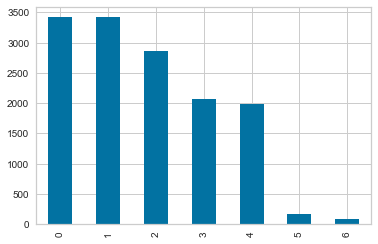

In [26]:
print("\nAnálise do novo atributo DIA_DA_SEMANA :")
df_completo['DIA_DA_SEMANA'].value_counts().sort_index().plot.bar();

### Perfil de dias de abertura de chamado
* Observa-se maior volume de abertura nas segundas e terças feiras
* a sexta-feira é o dia da semana com menor volume de abertura de chamado
* sabado e domingo são dias com menos abertura, por não ser dia útil

Agora é avaliar qual a influência da hora de abertura dos chamados

In [27]:
hora_abertura= df_completo["DATA_EMISSAO"].dt.hour # identifica qual é a hora de abertura do chamado 
df_completo["HORA_ABERTURA"] = hora_abertura   # Adiciona a coluna na base de dados.
print("\nTipos dos dados de chamados:\n{0}\n".format(df_completo["HORA_ABERTURA"].dtypes))
print("\nAnálise do novo atributo HORA_ABERTURA :")
print(df_completo["HORA_ABERTURA"].describe())



Tipos dos dados de chamados:
int64


Análise do novo atributo HORA_ABERTURA :
count    14013.000000
mean        12.485121
std          3.302243
min          0.000000
25%         10.000000
50%         12.000000
75%         15.000000
max         23.000000
Name: HORA_ABERTURA, dtype: float64


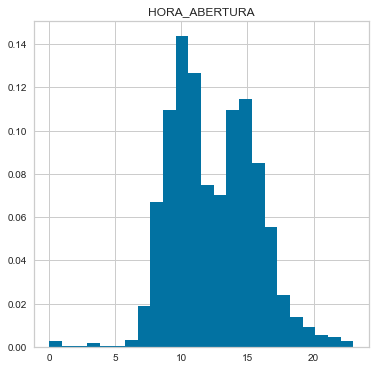

In [28]:
df_completo.hist(column='HORA_ABERTURA',    # Coluna a ser plotada
                   figsize=(6,6),   # Tamanho do gráfico
                   bins=24,
                density=True);         # Numero de colunas do histogram

### Perfil da hora de abertura dos chamados
* Percebe-se que há um comportamento do usuário de haver maior concentração de abertura de chamado entre 10 e 12 horas, bem como de 14 as 16 horas.

* Talvez possa ter alguma relação com o tempo previsto para atendimento dos chamados. Apesar dos usuários, em sua grande maioria, não terem um conhecimento prévio, pode ser que exista uma expectativa inconsciente por tras deste movimento de abertura de chamados. 
* Assim, é salutar avaliar o comportamento da ```DATA_RESOLVIDO ``` e ```TEMPO_PREVISTO_MINUTOS ``` 


In [29]:
df_completo["DATA_RESOLVIDO"] = pd.to_datetime(df_completo["DATA_RESOLVIDO"], dayfirst=True)
dia_da_semana= df_completo["DATA_RESOLVIDO"].dt.dayofweek # identifica qual é o dia da semana de abertura do chamado 
# 0 = Segunda-feira e 6 = Domingo
df_completo["DIA_DA_SEMANA_RESOLVIDO"] = dia_da_semana   # Adiciona a coluna na base de dados.



Análise do novo atributo DIA_DA_SEMANA_RESOLVIDO :


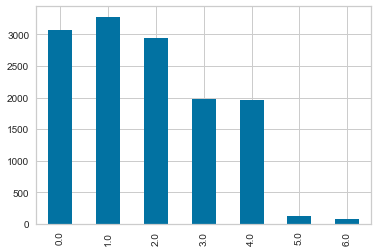

In [30]:
print("\nAnálise do novo atributo DIA_DA_SEMANA_RESOLVIDO :")

df_completo['DIA_DA_SEMANA_RESOLVIDO'].value_counts().sort_index().plot.bar();


In [31]:
hora_resolvido= df_completo["DATA_RESOLVIDO"].dt.hour # identifica qual é a hora do chamado resolvido 
df_completo["HORA_RESOLVIDO"] = hora_abertura   # Adiciona a coluna na base de dados.
print(df_completo["HORA_RESOLVIDO"].describe())


count    14013.000000
mean        12.485121
std          3.302243
min          0.000000
25%         10.000000
50%         12.000000
75%         15.000000
max         23.000000
Name: HORA_RESOLVIDO, dtype: float64



Análise do novo atributo HORA_RESOLVIDO :
count    14013.000000
mean        12.485121
std          3.302243
min          0.000000
25%         10.000000
50%         12.000000
75%         15.000000
max         23.000000
Name: HORA_RESOLVIDO, dtype: float64


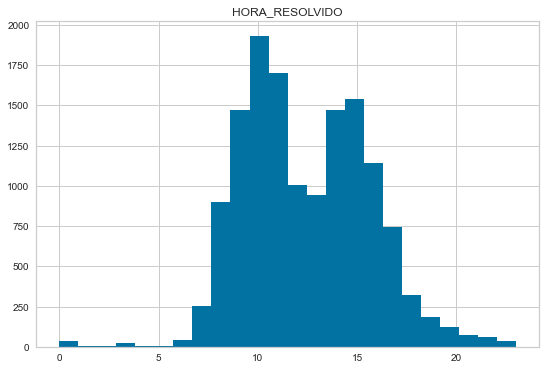

In [32]:
print("\nAnálise do novo atributo HORA_RESOLVIDO :")
print(df_completo["HORA_RESOLVIDO"].describe())


df_completo.hist(column='HORA_RESOLVIDO',    # Coluna a ser plotada
                   figsize=(9,6),   # Tamanho do gráfico
                   bins=24);         # Numero de colunas do histogram

### 3.2 Análise TEMPO_PREVISTO_MINUTOS

In [33]:
print("\nAnálise do  atributo TEMPO_PREVISTO_MINUTOS :")
print(df_completo["TEMPO_PREVISTO_MINUTOS"].describe())






Análise do  atributo TEMPO_PREVISTO_MINUTOS :
count     14013.000000
mean        708.170128
std        2278.660418
min           0.000000
25%         240.000000
50%         240.000000
75%         360.000000
max      114880.000000
Name: TEMPO_PREVISTO_MINUTOS, dtype: float64



Análise do atributo TEMP_PREVISTO_MINUTOS:
count     14013.000000
mean        708.170128
std        2278.660418
min           0.000000
10%          14.000000
20%         240.000000
30%         240.000000
40%         240.000000
50%         240.000000
60%         360.000000
70%         360.000000
80%         480.000000
90%        1200.000000
95%        3600.000000
96%        4320.000000
97%        4320.000000
98%        4320.000000
99%        4320.000000
max      114880.000000
Name: TEMPO_PREVISTO_MINUTOS, dtype: float64


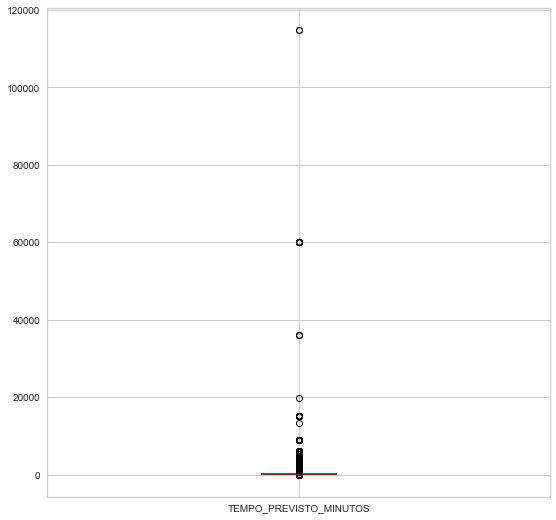

In [38]:
print("\nAnálise do atributo TEMP_PREVISTO_MINUTOS:")
print(df_completo["TEMPO_PREVISTO_MINUTOS"].describe([.1,.2,.3,.4,.5,.6,.7,.8,.9,.95,.96,.97,.98,.99]))
df_completo["TEMPO_PREVISTO_MINUTOS"].plot(kind="box", figsize=(9,9));


### 3.3 Análise TEMPO_CONSUMIDO


Análise do novo atributo TEMPO_CONSUMIDO :
count     14008.000000
mean        361.720303
std        6105.326957
min           0.000000
10%           0.000000
20%           1.000000
25%           3.000000
30%           7.000000
40%          16.000000
50%          29.000000
60%          46.000000
70%          70.000000
80%         107.000000
90%         198.000000
95%         489.000000
96%         681.320000
97%        1010.580000
98%        1573.860000
99%        3106.930000
max      397914.000000
Name: TEMPO_CONSUMIDO, dtype: float64


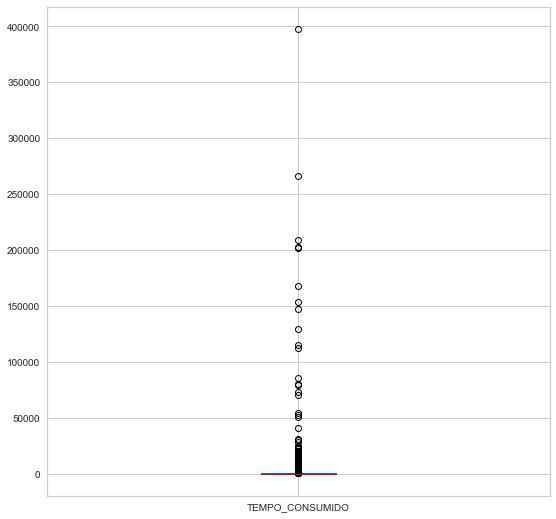

In [39]:
print("\nAnálise do novo atributo TEMPO_CONSUMIDO :")
print(df_completo["TEMPO_CONSUMIDO"].describe([.1,.2, .25,.3,.4,.5,.6,.7,.8,.9,.95,.96,.97,.98,.99]))
df_completo["TEMPO_CONSUMIDO"].plot(kind="box", figsize=(9,9));

### Observações
* ```TEMPO_CONSUMIDO``` está com valor zero em 10% dos dados. Isso significa que para o cálculo de nível de serviço, este valor foi zero ou não foi atendido pelo prestador. Estes valores podem ser retirado da base ou eventualmente preditos para valores considerando as datas de abertura e resolvido
* ```TEMPO_CONSUMIDO``` está com valor >0 e menor 7 minutos em até 30% dos chamados. Este valor não é tão usual para o tratamento de um chamado. Pode indicar tratamento anormal de chamado, pois é incomum um chamado ser atendido e fechado de maneira tão rápida

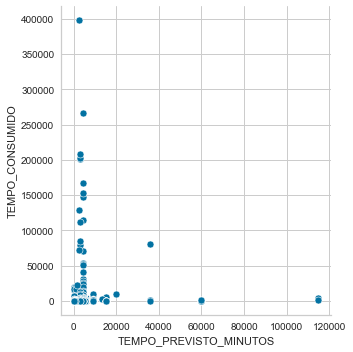

In [40]:
sns.relplot(x='TEMPO_PREVISTO_MINUTOS', y='TEMPO_CONSUMIDO', data = df_completo)

In [41]:
# Verifica a quantidade de tempo consumido nulo.
print(np.count_nonzero(np.isnan(df_completo["TEMPO_CONSUMIDO"])))
# Verifica a quantidade de tempo previsto nulo.
print(np.count_nonzero(np.isnan(df_completo["TEMPO_PREVISTO_MINUTOS"])))

5
0


### 3.4 Correlação variáveis

### Impacto do tempo previsto de atendimento e eventual relação com comportamento do usuário na abertura dos chamados

* O ```TEMPO_PREVISTO_MINUTOS``` tem um comportamento de ser mais frequente entre 240 minutos (4 horas úteis) 

* Se o usuário empiricamente sabe disso, seria interessante observar como se comporta o tempo efetivo ```TEMPO_CONSUMIDO ```, de forma a observar se existe um comportamento de o tempo ```TEMPO_CONSUMIDO ``` se aproximar do tempo do ```TEMPO_PREVISTO_MINUTOS```. A razão entre ```TEMPO_CONSUMIDO ``` e ```TEMPO_PREVISTO_MINUTOS``` quanto maior que 1, pode indicar que o comportamento do usuário não tem relação com o tempo previsto.

* Assim, é salutar avaliar esta relação, para verificar se o histórico do tempo efetivo ```TEMPO_CONSUMIDO ``` pode ter alguma inflência no comportamento do usuário para abertura de chamados.


In [42]:
corr_df = df_completo.corr()
print("A Correlação das váriaveis numéricas é dada por:")
print(corr_df, "\n")

A Correlação das váriaveis numéricas é dada por:
                         TEMPO_CONSUMIDO  TEMPO_DE_REACAO  \
TEMPO_CONSUMIDO                 1.000000         0.002141   
TEMPO_DE_REACAO                 0.002141         1.000000   
TEMPO_PREVISTO_MINUTOS          0.081228        -0.008356   
UA                             -0.002730         0.002854   
QTDE_ENCAMINHA                  0.055899        -0.020217   
DIA_DA_SEMANA                   0.002070         0.006480   
HORA_ABERTURA                   0.014592         0.017158   
DIA_DA_SEMANA_RESOLVIDO        -0.012962        -0.001903   
HORA_RESOLVIDO                  0.014592         0.017158   

                         TEMPO_PREVISTO_MINUTOS        UA  QTDE_ENCAMINHA  \
TEMPO_CONSUMIDO                        0.081228 -0.002730        0.055899   
TEMPO_DE_REACAO                       -0.008356  0.002854       -0.020217   
TEMPO_PREVISTO_MINUTOS                 1.000000  0.003189        0.093761   
UA                              

### 3.5 Feature Selection

In [43]:
df_completo.isnull().sum() # Verifica quais variáveis tem valores nulos

ACIONAMENTO                         0
ACIONAMENTO_VIA                     2
AGUARDANDO_USUARIO                  0
ARF                             12454
CATEGORIA                           0
CHAMADO_REABERTO                    0
CLIENTE                          3091
CPF                                 0
CRIADO_POR                          0
DATA_CONCLUIDO                   1187
DATA_EMISSAO                        0
DATA_HORA_FIM_ATEND             14013
DATA_HORA_INICIO_ATEND           1680
DATA_RESOLVIDO                    587
DATA_STATUS                         0
DESCRICAO_DEMANDA                   0
DESCRICAO_TKT_VINCULADO         13620
GRUPO_CRIACAO                   14013
GRUPO_GESTOR                        5
MUNICIPIO_ATENDIMENTO            1616
NIVEL_SEVERIDADE_INFRA              0
NOME                               33
NR_TICKET_VINCULADO             13599
NUMERO_TICKET                       0
OBSERVACAO                      14013
OC_RF                            3673
REDE_ASSISTI

* ```DATA_RESOLVIDO``` está como nulo em 587 registros. São registros que devem ser excluídos

In [44]:
df_completo.dropna(subset=['DATA_RESOLVIDO'], inplace=True)


### 3.5.1 REMOÇÃO DE ATRIBUTOS IRRELEVANTES

Os atributos ```ACIONAMENTO``` ,  ```AGUARDANDO_USUARIO```, ```CPF```, ```CRIADO_POR```, ```DESCRICAO_DEMANDA```, ```NOME```, ```OBSERVACAO```,   ```SOLUCAO_APLICADA```, ```AGUARDANDO PRESTADOR```,  ```EMAIL```, ```TIPO_TICKET_VINCULADO```, ```SUB_CATEGORIA```, ```TIPO_TICKET```, ```SITUACAO```   , ```STATUS```, ```DESCRICAO_TKT_VINCULADO```,  ```GRUPO_CRIACAO```, ```NUMERO_TICKET```, ```DATA_CONCLUIDO```, ```DATA_RESOLVIDO```, ```DATA_STATUS```, ```CHAMADO_REABERTO ```, ```NR_TICKET_VINCULADO``` ,  ```DATA_HORA_FIM_ATEND``` ,  ```DATA_HORA_INICIO_ATEND``` , ```RESPONSAVEL_PELO_ATENDIMENTO```  , ```SETOR ```  não são úteis para auxiliar na previsão do tempo de atendimento.


* ```AGUARDANDO_USUARIO```, ```AGUARDANDO PRESTADOR``` é apenas um identificador que indicar se o chamado após ser atendido precisou de aguardar o usuário tomar alguma ação ou precisou de algum prestador externo.

* ```CPF```, ```CRIADO_POR```, ```EMAIL```e ```NOME```  náo são úteis para previsão.

* ```DESCRICAO_DEMANDA```, ```OBSERVACAO```, ```SOLUCAO_APLICADA``` seriam utéis apenas se fosse utilizada alguma técnica de com base em NLP para prever o tempo de atendimento.

* ```TIPO_TICKET_VINCULADO```, ```DESCRICAO_TKT_VINCULADO```, ```SUB_CATEGORIA```, ```TIPO_TICKET```, ```GRUPO_CRIACAO```, ```NUMERO_TICKET```, ```ACIONAMENTO```, ```NR_TICKET_VINCULADO```, ```SETOR ```, ```NIVEL_SEVERIDADE_INFRA```  indicam valores únicos, unitários ou de nenhuma relevância para prevsão do tempo de atendimento.

* ```SITUACAO```   , ```STATUS``` são informações que não se tem no momento da abertura do chamado, portanto nenhuma relevância para prevsão do tempo de atendimento.

* ```DATA_CONCLUIDO```, ```DATA_RESOLVIDO```, ```DATA_STATUS```, ```CHAMADO_REABERTO ```, ```RESPONSAVEL_PELO_ATENDIMENTO```, e ```GRUPO_GESTOR```  são informações obtidas após o chamado ser finalizado ou tiver andamento. Não é informação que se tem no momento da abertura do chamado, portanto nenhuma relevância para prevsão do tempo de atendimento.
*  ```DATA_HORA_FIM_ATEND``` ,  ```DATA_HORA_INICIO_ATEND```  são as bases para calcular o tempo de reação. E o fim do atendimento inicial não se tem no nomento da abertura.

In [45]:
df_completo_antes_remocao = df_completo.copy(deep=True) # cria uma copia dos dados

In [46]:
del df_completo["ACIONAMENTO"]
del df_completo["AGUARDANDO_USUARIO"]
del df_completo["CPF"]
del df_completo["CRIADO_POR"]
del df_completo["DESCRICAO_DEMANDA"]
del df_completo["NOME"]
del df_completo["OBSERVACAO"]
del df_completo["SOLUCAO_APLICADA"]
del df_completo["AGUARDANDOPRESTADOR"]
del df_completo["EMAIL"]
del df_completo["TIPO_TICKET_VINCULADO"]
del df_completo["SUB_CATEGORIA"]
del df_completo["TIPO_TICKET"]
del df_completo["SITUACAO"]
del df_completo["STATUS"]
del df_completo["DESCRICAO_TKT_VINCULADO"]
del df_completo["DATA_CONCLUIDO"]
del df_completo["DATA_RESOLVIDO"]
del df_completo["DATA_STATUS"]
del df_completo["CHAMADO_REABERTO"]
del df_completo["NUMERO_TICKET"]
del df_completo["NR_TICKET_VINCULADO"]
del df_completo["DATA_HORA_FIM_ATEND"]
del df_completo["DATA_HORA_INICIO_ATEND"]
del df_completo["RESPONSAVEL_PELO_ATENDIMENTO"]
del df_completo["SETOR"]
del df_completo["GRUPO_CRIACAO"]
del df_completo["NIVEL_SEVERIDADE_INFRA"]
del df_completo["GRUPO_GESTOR"]

# As dimensões de chamados foram reduzidas

print("\nDimensões de Chamados:\n{0}\n".format(df_completo.shape))


Dimensões de Chamados:
(13426, 25)



### 3.5.2. Remoção de valores que são transformações de outros valores.
* ```UA``` indica o código da unidade do usuário que está abrindo o chamado. os campos como ```ARF```,  ```MUNICIPIO_ATENDIMENTO```, ```OC_RF```, ```UF``` e ```UNIDADE``` decorrem do campo UA, portanto, podem ser suprimidas nesta primeira análise.



In [47]:
# Excluindo informações redundantes
del df_completo["ARF"]
del df_completo["MUNICIPIO_ATENDIMENTO"]
del df_completo["OC_RF"]
del df_completo["UF"]
del df_completo["UNIDADE"]
print("\nDimensões de Chamados:\n{0}\n".format(df_completo.shape))
print("\nTipos dos dados de chamados:\n{0}\n".format(df_completo.dtypes))


Dimensões de Chamados:
(13426, 20)


Tipos dos dados de chamados:
ACIONAMENTO_VIA                    object
CATEGORIA                          object
CLIENTE                            object
DATA_EMISSAO               datetime64[ns]
REDE_ASSISTIDA                     object
SERVICO                            object
TEMPO_CONSUMIDO                   float64
TEMPO_DE_REACAO                     int64
TEMPO_PREVISTO_MINUTOS              int64
TIPO_RECURSO                       object
TIPO_USUARIO                       object
UA                                float64
UG_ATENDIMENTO                     object
UG_SERVICO                         object
QTDE_ENCAMINHA                      int64
GRUPO_DE                           object
DIA_DA_SEMANA                       int64
HORA_ABERTURA                       int64
DIA_DA_SEMANA_RESOLVIDO           float64
HORA_RESOLVIDO                      int64
dtype: object



In [48]:
# Para se ter uma visão dos atributos categóricos, os atributos não numéricos 
# não são exibidos. 


categ = df_completo.dtypes[df_completo.dtypes == "object"].index

print("\n", df_completo[categ].describe(), sep='\n')



       ACIONAMENTO_VIA                                          CATEGORIA  \
count            13424                                              13426   
unique              17                                                440   
top           INTERNET  ATENDIMENTO REMOTO A ESTAÇÕES DE TRABALHO/NOTE...   
freq              6624                                               6278   

       CLIENTE REDE_ASSISTIDA  \
count    10382          13426   
unique      30              2   
top        RFB            Sim   
freq      8475           9194   

                                                  SERVICO TIPO_RECURSO  \
count                                               13409         3673   
unique                                                751         1399   
top     ATENDIMENTO REMOTO,ATENDIMENTO REMOTO A ESTAÇÕ...        36043   
freq                                                 6277          282   

       TIPO_USUARIO UG_ATENDIMENTO UG_SERVICO       GRUPO_DE  
count       

In [49]:
df_completo.isnull().sum() # Verifica quais variáveis tem valores nulos

ACIONAMENTO_VIA               2
CATEGORIA                     0
CLIENTE                    3044
DATA_EMISSAO                  0
REDE_ASSISTIDA                0
SERVICO                      17
TEMPO_CONSUMIDO               3
TEMPO_DE_REACAO               0
TEMPO_PREVISTO_MINUTOS        0
TIPO_RECURSO               9753
TIPO_USUARIO                 58
UA                         3582
UG_ATENDIMENTO                0
UG_SERVICO                   17
QTDE_ENCAMINHA                0
GRUPO_DE                      0
DIA_DA_SEMANA                 0
HORA_ABERTURA                 0
DIA_DA_SEMANA_RESOLVIDO       0
HORA_RESOLVIDO                0
dtype: int64

### 3.5.3. Remoção de valores NULOS: TEMPO_CONSUMIDO, UA e CATEGORIA

* Os registros com ```TEMPO_CONSUMIDO``` igual a nulo, significa que ainda não foi completamente fechado, portanto, pode ser excluído da base
* As variáveis ```UA``` e ```CATEGORIA``` são responsáveis, no âmbito da Receita Federal, para determinar o ```TEMPO_PREVISTO_MINUTOS```, portanto, não podem ser nulos, assim, estes registros devem ser desconsiderados.


In [50]:
df_completo.dropna(subset=['TEMPO_CONSUMIDO'], inplace=True)
df_completo.dropna(subset=['UA'], inplace=True)
df_completo.dropna(subset=['CATEGORIA'], inplace=True)
df_completo.isnull().sum() # Verifica quais variáveis tem valores nulos

ACIONAMENTO_VIA               0
CATEGORIA                     0
CLIENTE                      32
DATA_EMISSAO                  0
REDE_ASSISTIDA                0
SERVICO                      17
TEMPO_CONSUMIDO               0
TEMPO_DE_REACAO               0
TEMPO_PREVISTO_MINUTOS        0
TIPO_RECURSO               7595
TIPO_USUARIO                 20
UA                            0
UG_ATENDIMENTO                0
UG_SERVICO                   10
QTDE_ENCAMINHA                0
GRUPO_DE                      0
DIA_DA_SEMANA                 0
HORA_ABERTURA                 0
DIA_DA_SEMANA_RESOLVIDO       0
HORA_RESOLVIDO                0
dtype: int64

In [51]:
print("\nDimensões de Chamados:\n{0}\n".format(df_completo.shape));
print("\nTipos dos dados de chamados:\n{0}\n".format(df_completo.dtypes));



Dimensões de Chamados:
(9842, 20)


Tipos dos dados de chamados:
ACIONAMENTO_VIA                    object
CATEGORIA                          object
CLIENTE                            object
DATA_EMISSAO               datetime64[ns]
REDE_ASSISTIDA                     object
SERVICO                            object
TEMPO_CONSUMIDO                   float64
TEMPO_DE_REACAO                     int64
TEMPO_PREVISTO_MINUTOS              int64
TIPO_RECURSO                       object
TIPO_USUARIO                       object
UA                                float64
UG_ATENDIMENTO                     object
UG_SERVICO                         object
QTDE_ENCAMINHA                      int64
GRUPO_DE                           object
DIA_DA_SEMANA                       int64
HORA_ABERTURA                       int64
DIA_DA_SEMANA_RESOLVIDO           float64
HORA_RESOLVIDO                      int64
dtype: object



In [52]:
categ = df_completo.dtypes[df_completo.dtypes == "object"].index
print("\n", df_completo[categ].describe(), sep='\n')



       ACIONAMENTO_VIA                                          CATEGORIA  \
count             9842                                               9842   
unique              15                                                294   
top           INTERNET  ATENDIMENTO REMOTO A ESTAÇÕES DE TRABALHO/NOTE...   
freq              5624                                               6264   

       CLIENTE REDE_ASSISTIDA  \
count     9810           9842   
unique       6              2   
top        RFB            Sim   
freq      8394           8741   

                                                  SERVICO TIPO_RECURSO  \
count                                                9825         2247   
unique                                                442         1142   
top     ATENDIMENTO REMOTO,ATENDIMENTO REMOTO A ESTAÇÕ...        36043   
freq                                                 6263          270   

       TIPO_USUARIO UG_ATENDIMENTO UG_SERVICO          GRUPO_DE  
count    

In [53]:
print("\nDimensões de Chamados:\n{0}\n".format(df_completo.shape))


Dimensões de Chamados:
(9842, 20)



In [54]:
# Excluindo informações redundantes
del df_completo["TIPO_RECURSO"]
del df_completo["SERVICO"]
del df_completo["DIA_DA_SEMANA_RESOLVIDO"]
del df_completo["HORA_RESOLVIDO"]
del df_completo["UG_ATENDIMENTO"]
del df_completo["UG_SERVICO"]
del df_completo["TEMPO_DE_REACAO"]
del df_completo["DATA_EMISSAO"] 
print("\nDimensões de Chamados:\n{0}\n".format(df_completo.shape))
print("\nTipos dos dados de chamados:\n{0}\n".format(df_completo.dtypes))


Dimensões de Chamados:
(9842, 12)


Tipos dos dados de chamados:
ACIONAMENTO_VIA            object
CATEGORIA                  object
CLIENTE                    object
REDE_ASSISTIDA             object
TEMPO_CONSUMIDO           float64
TEMPO_PREVISTO_MINUTOS      int64
TIPO_USUARIO               object
UA                        float64
QTDE_ENCAMINHA              int64
GRUPO_DE                   object
DIA_DA_SEMANA               int64
HORA_ABERTURA               int64
dtype: object



In [55]:
df_completo.isnull().sum() # Verifica quais variáveis tem valores nulos

ACIONAMENTO_VIA            0
CATEGORIA                  0
CLIENTE                   32
REDE_ASSISTIDA             0
TEMPO_CONSUMIDO            0
TEMPO_PREVISTO_MINUTOS     0
TIPO_USUARIO              20
UA                         0
QTDE_ENCAMINHA             0
GRUPO_DE                   0
DIA_DA_SEMANA              0
HORA_ABERTURA              0
dtype: int64

In [56]:
categ = df_completo.dtypes[df_completo.dtypes == "object"].index

print("\n", df_completo[categ].describe(), sep='\n')



       ACIONAMENTO_VIA                                          CATEGORIA  \
count             9842                                               9842   
unique              15                                                294   
top           INTERNET  ATENDIMENTO REMOTO A ESTAÇÕES DE TRABALHO/NOTE...   
freq              5624                                               6264   

       CLIENTE REDE_ASSISTIDA TIPO_USUARIO          GRUPO_DE  
count     9810           9842         9822              9842  
unique       6              2            4               257  
top        RFB            Sim      Externo  GSOPBRARLARF08SR  
freq      8394           8741         7496              1147  


### O que determina o tempo previsto de atendimento e o encaminhamento para atendimento ??

* Resposta: É a ```CATEGORIA``` e a ```UA``` do usuário. Desta forma, para uma análise inicial, para analisar um modelo mais simples, é de se supor que seja razóavel excluir as variáveis de ```SERVIÇO```, ```TIPO_RECURSO ```, ```UG_ATENDIMENTO ``` e ```UG_SERVICO ```

* Outro ponto importante é que a Variável ```UA``` que tem o código da UA é um valor numérico, mas sua função é ser categórica, significando o "nome" da unidade do usuário. Portanto, é necessário converter o seu tipo para categorico.



In [58]:
df_completo["CATEGORIA"] = pd.Categorical(df_completo["CATEGORIA"])
df_completo["ACIONAMENTO_VIA"] = pd.Categorical(df_completo["ACIONAMENTO_VIA"])
df_completo["CLIENTE"] = pd.Categorical(df_completo["CLIENTE"])
df_completo["REDE_ASSISTIDA"] = pd.Categorical(df_completo["REDE_ASSISTIDA"])
df_completo["TIPO_USUARIO"] = pd.Categorical(df_completo["TIPO_USUARIO"])
df_completo["UA"] = pd.Categorical(df_completo["UA"])
df_completo["DIA_DA_SEMANA"] = pd.Categorical(df_completo["DIA_DA_SEMANA"])
df_completo["GRUPO_DE"] = pd.Categorical(df_completo["GRUPO_DE"])
print("\nTipos dos dados de chamados:\n{0}\n".format(df_completo.dtypes))


Tipos dos dados de chamados:
ACIONAMENTO_VIA           category
CATEGORIA                 category
CLIENTE                   category
REDE_ASSISTIDA            category
TEMPO_CONSUMIDO            float64
TEMPO_PREVISTO_MINUTOS       int64
TIPO_USUARIO              category
UA                        category
QTDE_ENCAMINHA               int64
GRUPO_DE                  category
DIA_DA_SEMANA             category
HORA_ABERTURA                int64
dtype: object



## 4. Machine Learning

## Início de tentativa de previsão do tempo de atendimento
* A com as exclusões, tratamentos e conversão de dados, propõe-se elaborar um primeiro modelo de previsão do tempo de atendimento, variável que no dados é chamada de ```TEMPO CONSUMIDO```

* Para isso, sugere-se utilizar o Pycaret

### Importante
* O Pycaret, na atual data, funciona até a versão 3.8 do Python. A versão do Python na última versão do Anaconda 3.9.12. Assim, foi necessário ao tentar executar o comando de instalação do Pycaret, mensagens de erro de falha na instalação eram exibidas. 

* Para solucionar o problema, foi necessário criar um novo ambiente com a versão 3.8 do Python no Anaconda.

## 4.1. - Setup 1 - Machine Learning

#### 4.1.1 - Criação das bases de testes e treinamento -  - Setup 1

In [59]:
pyc_chamados = df_completo # copiando a base de chamados para iniciar o trabalho com a Pycaret


In [60]:
pyc_chamados.shape # Exibe o shape da base completa

(9842, 12)

In [61]:
pyc_chamados.describe()  # Exibe a descrição das variáveis númericas da base integral. 
#Observar que o campo Dia_da_semana não está mais presente

,TEMPO_CONSUMIDO,TEMPO_PREVISTO_MINUTOS,QTDE_ENCAMINHA,HORA_ABERTURA
count,9842.000000,9842.000000,9842.000000,9842.000000
mean,259.347592,514.164906,3.837228,12.262955
std,4561.223915,1618.506395,5.300590,3.068527
min,0.000000,0.000000,0.000000,0.000000
25%,10.000000,240.000000,2.000000,10.000000
50%,38.000000,240.000000,3.000000,12.000000
75%,90.000000,360.000000,4.000000,15.000000
max,265940.000000,114880.000000,332.000000,23.000000


In [62]:
pyc_chamados_train = pyc_chamados.sample(frac=0.8, random_state=153) # cria a base de treinamento em 80% da original
pyc_chamados_train.shape # Exibe o shape da base de treinamento


(7874, 12)

In [63]:
pyc_chamados_test = pyc_chamados.drop(pyc_chamados_train.index) # cria a base de teste em 20% da original

In [64]:
pyc_chamados_test.shape # Exibe o shape da base de teste

(1968, 12)

In [65]:
pyc_chamados_test.head() # Exibe os primeiros elementos da base de teste

,ACIONAMENTO_VIA,CATEGORIA,CLIENTE,REDE_ASSISTIDA,TEMPO_CONSUMIDO,TEMPO_PREVISTO_MINUTOS,TIPO_USUARIO,UA,QTDE_ENCAMINHA,GRUPO_DE,DIA_DA_SEMANA,HORA_ABERTURA
1,INTERNET,ATENDIMENTO REMOTO A ESTAÇÕES DE TRABALHO/NOTE...,RFB,Sim,71.0,240,Externo,1017700.0,5,GSOPBRARLARF10SR,1,10
3,INTERNET,INSTALAÇÃO OU CONFIGURAÇÃO PRESENCIAL DE ESTAÇ...,RFB,Sim,133.0,1200,Externo,1017700.0,11,GSOPRSARLAALFRGE,4,9
9,SOLICORP RFB,ATENDIMENTO REMOTO A ESTAÇÕES DE TRABALHO/NOTE...,RFB,Sim,58.0,240,Externo,1017700.0,1,GSOPBRARLARF10SR,4,15
11,SOLICORP RFB,ATENDIMENTO REMOTO A ESTAÇÕES DE TRABALHO/NOTE...,RFB,Sim,17.0,240,Externo,1017700.0,2,GSOPBRARLARF10SR,4,15
15,SOLICORP RFB,ATENDIMENTO REMOTO A ESTAÇÕES DE TRABALHO/NOTE...,RFB,Sim,36.0,240,Externo,1017700.0,2,GSOPBRARLARF10SR,4,15


In [66]:
pyc_chamados_train.reset_index(drop=True, inplace=True) # modifica os indices da base de treinamento

In [67]:
pyc_chamados_train.head() # Confere a renumeração os indices da base de treinamento

,ACIONAMENTO_VIA,CATEGORIA,CLIENTE,REDE_ASSISTIDA,TEMPO_CONSUMIDO,TEMPO_PREVISTO_MINUTOS,TIPO_USUARIO,UA,QTDE_ENCAMINHA,GRUPO_DE,DIA_DA_SEMANA,HORA_ABERTURA
0,INTRANET,ATENDIMENTO REMOTO A ESTAÇÕES DE TRABALHO/NOTE...,SERPRO,Sim,13.0,720,Interno,700100.0,3,GSOPRJARLIRFB,1,9
1,USUÁRIO INTERNO,MANUTENÇÃO LÓGICA DE SERVIÇO OU SERVIDOR,SERPRO,Sim,27.0,720,Interno,1000100.0,3,GSOPBRARLARF10SR,2,15
2,SOLICORP RFB,SUITE DE APLICATIVOS RFB / AMBIENTE /,RFB,Sim,137.0,360,Externo,710822.0,2,ATGSSPRFB,1,10
3,INTERNET,ATENDIMENTO REMOTO A ESTAÇÕES DE TRABALHO/NOTE...,SERPRO,Sim,10.0,720,Interno,700100.0,2,GSOPBRARLARF07SR,0,15
4,SOLICORP RFB,ATENDIMENTO REMOTO A ESTAÇÕES DE TRABALHO/NOTE...,RFB,Não,36.0,240,Externo,710202.0,3,GSOPBRARLARF07SR,3,10


In [68]:
pyc_chamados_test.reset_index(drop=True, inplace=True) # modifica os indices da base de teste

In [69]:
pyc_chamados_test.head() # Confere a renumeração os indices da base de teste

,ACIONAMENTO_VIA,CATEGORIA,CLIENTE,REDE_ASSISTIDA,TEMPO_CONSUMIDO,TEMPO_PREVISTO_MINUTOS,TIPO_USUARIO,UA,QTDE_ENCAMINHA,GRUPO_DE,DIA_DA_SEMANA,HORA_ABERTURA
0,INTERNET,ATENDIMENTO REMOTO A ESTAÇÕES DE TRABALHO/NOTE...,RFB,Sim,71.0,240,Externo,1017700.0,5,GSOPBRARLARF10SR,1,10
1,INTERNET,INSTALAÇÃO OU CONFIGURAÇÃO PRESENCIAL DE ESTAÇ...,RFB,Sim,133.0,1200,Externo,1017700.0,11,GSOPRSARLAALFRGE,4,9
2,SOLICORP RFB,ATENDIMENTO REMOTO A ESTAÇÕES DE TRABALHO/NOTE...,RFB,Sim,58.0,240,Externo,1017700.0,1,GSOPBRARLARF10SR,4,15
3,SOLICORP RFB,ATENDIMENTO REMOTO A ESTAÇÕES DE TRABALHO/NOTE...,RFB,Sim,17.0,240,Externo,1017700.0,2,GSOPBRARLARF10SR,4,15
4,SOLICORP RFB,ATENDIMENTO REMOTO A ESTAÇÕES DE TRABALHO/NOTE...,RFB,Sim,36.0,240,Externo,1017700.0,2,GSOPBRARLARF10SR,4,15


#### 4.1.2 - Criação dos modelos - Setup 1

In [70]:
regpos = pycr.setup (data = pyc_chamados_train,
               target = "TEMPO_CONSUMIDO",
               session_id= 123)

,Description,Value
0,session_id,123
1,Target,TEMPO_CONSUMIDO
2,Original Data,"(7874, 12)"
3,Missing Values,True
4,Numeric Features,3
5,Categorical Features,8
6,Ordinal Features,False
7,High Cardinality Features,False
8,High Cardinality Method,None
9,Transformed Train Set,"(5511, 829)"


In [71]:
best = pycr.compare_models(exclude = ["ransac"])


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
huber,Huber Regressor,193.5975,16291856.5312,2419.2002,0.0913,1.3894,1.9466,4.6350
par,Passive Aggressive Regressor,209.8569,16049287.5657,2398.6903,0.0230,1.5989,4.6996,0.1200
dummy,Dummy Regressor,320.0981,16444300.0695,2464.1508,-0.0669,2.7746,13.7864,0.0370
ada,AdaBoost Regressor,238.2576,8912117.4382,1634.0077,-0.0785,2.3167,8.7667,1.3150
knn,K Neighbors Regressor,231.4699,17114079.2609,2702.6358,-1.0136,1.1455,2.4070,0.6130
gbr,Gradient Boosting Regressor,218.1037,10307601.3862,2031.7470,-1.0508,1.8661,4.1595,1.5550
br,Bayesian Ridge,296.1279,16195758.4893,2595.6524,-1.8483,2.3168,10.4057,1.2790
en,Elastic Net,305.9739,16181660.2156,2613.0643,-1.9468,2.3538,7.9429,0.1110
et,Extra Trees Regressor,261.4904,22446961.9087,3114.5104,-2.3855,1.0972,2.7900,10.7400
lightgbm,Light Gradient Boosting Machine,305.6150,14087742.1514,2571.1490,-3.4055,1.7993,5.0913,0.1050


#### 4.1.3 - Escolha melhor modelo e Tunning - Setup 1¶

In [72]:
modelo0 = pycr.create_model("huber")


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,90.8201,108841.0727,329.9107,0.2327,1.4438,1.9700
1,104.4588,322824.1469,568.1762,0.1025,1.3946,2.2165
2,107.8814,238286.1795,488.1457,0.0209,1.3670,2.2087
3,150.6170,875360.8438,935.6072,0.0755,1.4084,1.9330
4,459.9038,74533091.4272,8633.2550,0.0011,1.4005,1.5854
5,103.2684,273011.1478,522.5047,0.1012,1.2859,1.8448
6,101.0827,246615.1074,496.6036,0.0998,1.3923,1.6767
7,240.9918,11295481.6479,3360.8751,0.0729,1.3284,1.6135
8,71.7543,38996.2070,197.4746,0.2054,1.4791,2.1787


In [73]:
tuned_modelo0 = pycr.tune_model(modelo0)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,90.9627,107270.3467,327.5215,0.2438,1.4681,2.4757
1,104.0849,319329.3705,565.0924,0.1122,1.4009,2.7307
2,109.3977,239186.0423,489.0665,0.0172,1.4240,2.7358
3,150.7967,866653.4109,930.9422,0.0847,1.4846,2.2723
4,460.7684,74488411.5472,8630.6669,0.0017,1.4709,2.0461
5,104.1449,272425.0136,521.9435,0.1032,1.3481,2.1624
6,102.3447,246546.6545,496.5346,0.1000,1.4447,2.0488
7,241.3674,11266161.9433,3356.5104,0.0754,1.3864,1.9729
8,73.0628,38766.5709,196.8923,0.2101,1.5220,2.8038


#### 4.1.4 - Resultados- Setup 1¶

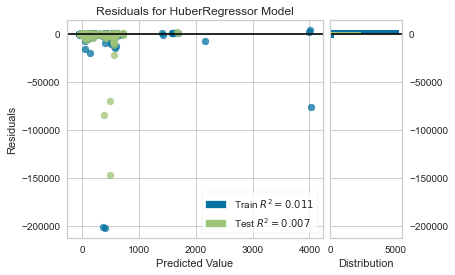

In [74]:
pycr.plot_model(tuned_modelo0)

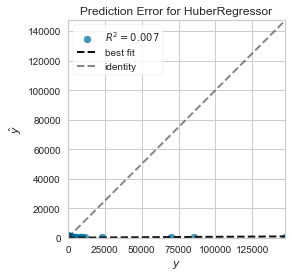

In [75]:
pycr.plot_model(tuned_modelo0, plot="error")

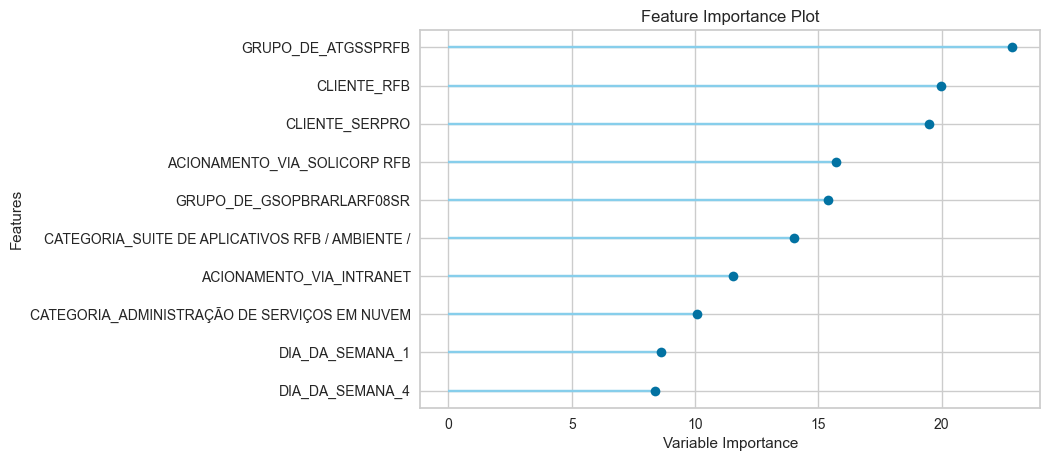

In [76]:
pycr.plot_model(tuned_modelo0, plot="feature")

In [77]:
resultado_modelo_treinado = pycr.predict_model(tuned_modelo0, data=pyc_chamados_train) # faz a previsão em toda base treinada.

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Huber Regressor,210.7434,15780803.3263,3972.5059,0.0102,1.5205,2.4785


In [81]:
test_predict = pycr.predict_model(tuned_modelo0, data=pyc_chamados_test)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Huber Regressor,327.7882,40146032.9162,6336.0897,0.0022,1.5440,2.4146


##### Houve a previsão de tempos negativos. Estes valores podem ser significativos e poderiam ser tratados

In [83]:
percen_tempo_negativo = 100*len(test_predict.loc[(test_predict['Label']<0)])/len(test_predict)
print("Percentual previsão com tempo negativo :", percen_tempo_negativo)

Percentual previsão com tempo negativo : 2.2357723577235773


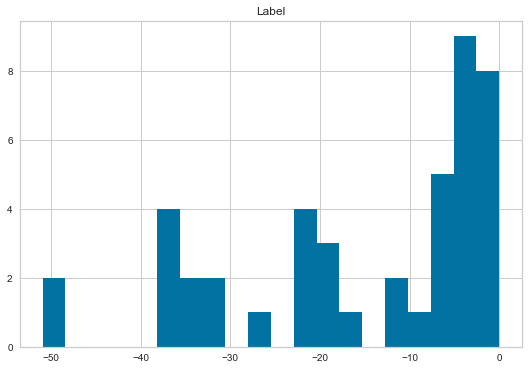

In [84]:
menor_zero = test_predict.loc[(test_predict['Label']<=0)] # retorna previsões menores que zero
menor_zero.hist(column='Label',    # Coluna a ser plotada
                   figsize=(9,6),   # Tamanho do gráfico
                   bins=20);         # Numero de colunas do histogram

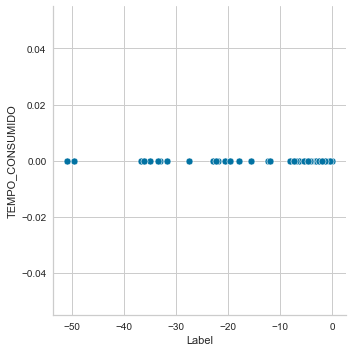

In [85]:
sns.relplot(x='Label', y='TEMPO_CONSUMIDO', data = menor_zero)

In [86]:
test_predict.head()


,ACIONAMENTO_VIA,CATEGORIA,CLIENTE,REDE_ASSISTIDA,TEMPO_CONSUMIDO,TEMPO_PREVISTO_MINUTOS,TIPO_USUARIO,UA,QTDE_ENCAMINHA,GRUPO_DE,DIA_DA_SEMANA,HORA_ABERTURA,Label
0,INTERNET,ATENDIMENTO REMOTO A ESTAÇÕES DE TRABALHO/NOTE...,RFB,Sim,71.0,240,Externo,1017700.0,5,GSOPBRARLARF10SR,1,10,64.123822
1,INTERNET,INSTALAÇÃO OU CONFIGURAÇÃO PRESENCIAL DE ESTAÇ...,RFB,Sim,133.0,1200,Externo,1017700.0,11,GSOPRSARLAALFRGE,4,9,175.739757
2,SOLICORP RFB,ATENDIMENTO REMOTO A ESTAÇÕES DE TRABALHO/NOTE...,RFB,Sim,58.0,240,Externo,1017700.0,1,GSOPBRARLARF10SR,4,15,35.072927
3,SOLICORP RFB,ATENDIMENTO REMOTO A ESTAÇÕES DE TRABALHO/NOTE...,RFB,Sim,17.0,240,Externo,1017700.0,2,GSOPBRARLARF10SR,4,15,39.153374
4,SOLICORP RFB,ATENDIMENTO REMOTO A ESTAÇÕES DE TRABALHO/NOTE...,RFB,Sim,36.0,240,Externo,1017700.0,2,GSOPBRARLARF10SR,4,15,39.153374


#### 4.1.5 - Análises e tentativas de melhoria - Setup 1¶
##### A REGRESSÃO NÃO APRESENTA UM MODELO SATISFATÓRIO. 
* Alguns atributos podem não estar adequados. Observando a distribuição de tempo previsto, pode haver um nicho de valores comprometendo os resultados



Análise do atributo TEMPO_PREVISTO_MINUTOS:
count     7874.000000
mean       505.255652
std       1182.134378
min          0.000000
10%          0.000000
20%        240.000000
30%        240.000000
40%        240.000000
50%        240.000000
60%        240.000000
70%        240.000000
80%        360.000000
90%        720.000000
95%       1440.000000
96%       3200.000000
97%       3600.000000
98%       4320.000000
99%       4320.000000
max      36000.000000
Name: TEMPO_PREVISTO_MINUTOS, dtype: float64


<AxesSubplot:>

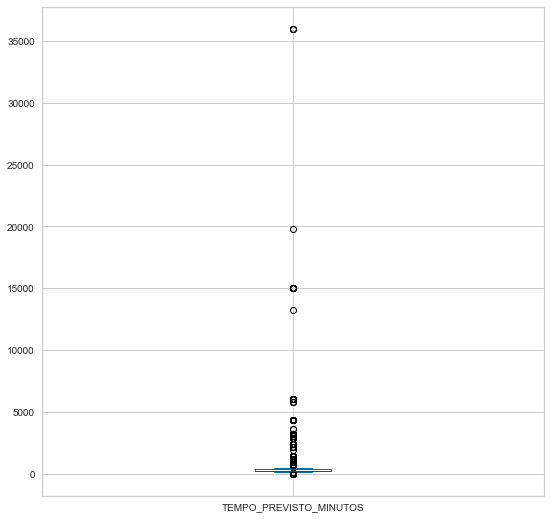

In [87]:
print("\nAnálise do atributo TEMPO_PREVISTO_MINUTOS:")
print(pyc_chamados_train["TEMPO_PREVISTO_MINUTOS"].describe([.1,.2,.3,.4,.5,.6,.7,.8,.9,.95,.96,.97,.98,.99]))
pyc_chamados_train["TEMPO_PREVISTO_MINUTOS"].plot(kind="box", figsize=(9,9))


Análise do atributo TEMPO CONSUMIDO:
count      7874.000000
mean        237.293625
std        3993.118856
min           0.000000
10%           0.000000
20%           5.000000
30%          15.000000
40%          25.000000
50%          38.000000
60%          53.000000
70%          75.000000
80%         107.000000
90%         179.000000
95%         356.000000
96%         464.000000
97%         712.000000
98%        1162.320000
99%        2315.810000
max      202639.000000
Name: TEMPO_CONSUMIDO, dtype: float64


<AxesSubplot:>

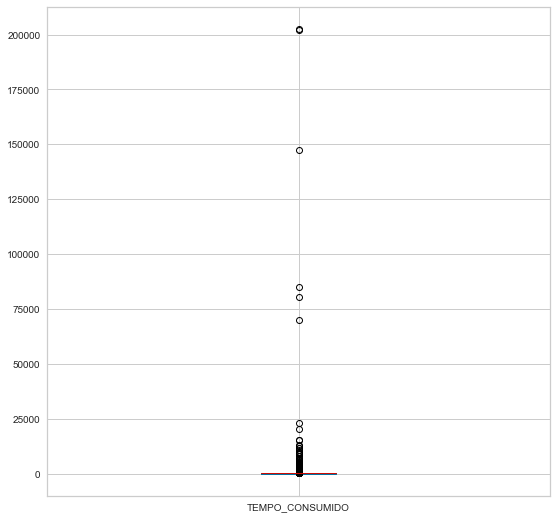

In [88]:
print("\nAnálise do atributo TEMPO CONSUMIDO:")
print(pyc_chamados_train["TEMPO_CONSUMIDO"].describe([.1,.2,.3,.4,.5,.6,.7,.8,.9,.95,.96,.97,.98,.99]))
pyc_chamados_train["TEMPO_CONSUMIDO"].plot(kind="box", figsize=(9,9))

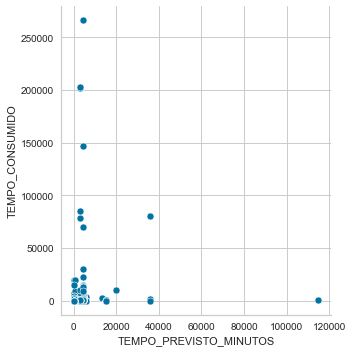

In [89]:
sns.relplot(x='TEMPO_PREVISTO_MINUTOS', y='TEMPO_CONSUMIDO', data = df_completo)

In [90]:
df_completo['GRUPO_DE'].describe()


count                 9842
unique                 257
top       GSOPBRARLARF08SR
freq                  1147
Name: GRUPO_DE, dtype: object

### Influência de outliers 1ª tentativa
* Retirar da base chamados com ```TEMPO_PREVISTO_MINUTOS``` > 4320 MINUTOS
* Aplicar normalização na base.
* Retirar da base chamados com ```TEMPO_CONSUMIDO``` = 0 MINUTOS, mantendo as anomalias de ```TEMPO_CONSUMIDO``` menor que 5 minutos

#### 4.2.1 - Criação das bases de testes e treinamento -  Setup 2

In [91]:
#removendo chamados com tempo previsto = 0 ou maior  4320 minutos úteis (90% dos chamados tem tempo_previsto < 720 minutos)  
df_remove = df_completo.loc[(df_completo['TEMPO_PREVISTO_MINUTOS']>4320) | (df_completo['TEMPO_CONSUMIDO']==0)] 
df_remove.describe()


,TEMPO_CONSUMIDO,TEMPO_PREVISTO_MINUTOS,QTDE_ENCAMINHA,HORA_ABERTURA
count,1452.000000,1452.000000,1452.000000,1452.000000
mean,71.582645,407.568871,2.180441,12.312672
std,2130.942165,3720.525107,1.756493,3.422877
min,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,1.000000,10.000000
50%,0.000000,0.000000,2.000000,12.000000
75%,0.000000,14.000000,3.000000,15.000000
max,80451.000000,114880.000000,21.000000,23.000000


In [92]:
df_ajuste1 =  df_completo.drop(df_remove.index)

In [93]:
df_ajuste1.shape, df_completo.shape


((8390, 12), (9842, 12))

In [94]:
df_ajuste1.dtypes


ACIONAMENTO_VIA           category
CATEGORIA                 category
CLIENTE                   category
REDE_ASSISTIDA            category
TEMPO_CONSUMIDO            float64
TEMPO_PREVISTO_MINUTOS       int64
TIPO_USUARIO              category
UA                        category
QTDE_ENCAMINHA               int64
GRUPO_DE                  category
DIA_DA_SEMANA             category
HORA_ABERTURA                int64
dtype: object

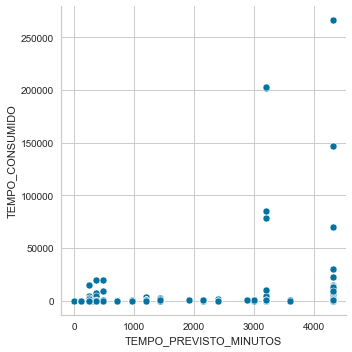

In [95]:
sns.relplot(x='TEMPO_PREVISTO_MINUTOS', y='TEMPO_CONSUMIDO', data = df_ajuste1)

In [96]:
df_ajuste1.isnull().sum() # Verifica quais variáveis tem valores nulos

ACIONAMENTO_VIA            0
CATEGORIA                  0
CLIENTE                    5
REDE_ASSISTIDA             0
TEMPO_CONSUMIDO            0
TEMPO_PREVISTO_MINUTOS     0
TIPO_USUARIO              16
UA                         0
QTDE_ENCAMINHA             0
GRUPO_DE                   0
DIA_DA_SEMANA              0
HORA_ABERTURA              0
dtype: int64

In [98]:
pyc_chamados_a1 = df_ajuste1
pyc_chamados_a1.describe()

,TEMPO_CONSUMIDO,TEMPO_PREVISTO_MINUTOS,QTDE_ENCAMINHA,HORA_ABERTURA
count,8390.000000,8390.000000,8390.000000,8390.000000
mean,291.842789,532.612753,4.123957,12.254350
std,4859.336936,822.454095,5.645201,3.003102
min,1.000000,1.000000,0.000000,0.000000
25%,20.000000,240.000000,2.000000,10.000000
50%,48.000000,240.000000,3.000000,12.000000
75%,101.000000,360.000000,4.000000,15.000000
max,265940.000000,4320.000000,332.000000,23.000000


In [99]:
pyc_chamados_a1_train = pyc_chamados_a1.sample(frac=0.8, random_state=153) # cria a base de treinamento em 80% da original

In [100]:
pyc_chamados_a1_train.shape # Exibe o shape da base de treinamento

(6712, 12)

In [101]:
pyc_chamados_a1_test = pyc_chamados_a1.drop(pyc_chamados_a1_train.index) 

In [102]:
pyc_chamados_a1_test.shape # Exibe o shape da base de teste

(1678, 12)

In [103]:
pyc_chamados_a1_train.reset_index(drop=True, inplace=True) # modifica os indices da base de treinamento

In [104]:
pyc_chamados_a1_test.reset_index(drop=True, inplace=True) # modifica os indices da base de teste

#### 4.2.2 - Criação dos modelos - Setup 2

In [105]:
regpos_a1 = pycr.setup (data = pyc_chamados_a1_train,
               target = "TEMPO_CONSUMIDO", 
               normalize = True, #incluindo normalização na base
               numeric_features = ['TEMPO_PREVISTO_MINUTOS'], #nesta simulação, incluido porque Pycaret está considerando categorico
               session_id= 234)

,Description,Value
0,session_id,234
1,Target,TEMPO_CONSUMIDO
2,Original Data,"(6712, 12)"
3,Missing Values,True
4,Numeric Features,3
5,Categorical Features,8
6,Ordinal Features,False
7,High Cardinality Features,False
8,High Cardinality Method,None
9,Transformed Train Set,"(4698, 678)"


In [106]:
best_a1 = pycr.compare_models(exclude = ["ransac"])


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
huber,Huber Regressor,242.9420,25351829.0371,3011.9935,0.1365,1.1041,2.1670,3.0150
par,Passive Aggressive Regressor,243.1403,25346577.9123,3014.8237,0.1287,1.1207,2.3341,0.3280
dummy,Dummy Regressor,414.6274,25544648.9758,3078.2825,-0.0722,2.2447,17.9052,0.0420
en,Elastic Net,364.8492,25016701.3328,3037.9386,-0.2378,1.8090,9.3315,0.0590
knn,K Neighbors Regressor,306.0924,27179073.4203,3353.8630,-0.7504,1.1377,2.6518,0.6730
lightgbm,Light Gradient Boosting Machine,457.3981,26654168.6762,3545.2880,-5.0493,1.4488,6.8534,0.0950
ridge,Ridge Regression,736.7469,26865761.6500,3780.2206,-8.8969,2.3503,33.1702,0.0590
llar,Lasso Least Angle Regression,389.0145,27847429.3954,3706.2187,-9.1066,2.0152,9.7170,0.7370
lasso,Lasso Regression,497.5095,27793032.3688,3745.8432,-9.9831,1.9249,16.2082,0.1460
omp,Orthogonal Matching Pursuit,521.3276,27785199.3063,3827.6871,-11.1248,1.8195,17.6192,0.0690


#### 4.2.3 - Escolha melhor modelo e Tunning - Setup 2¶
* Pela diferença de tempo de execução o algoritmo PAR foi escolhido em detrimento do HUber. R2 quase identicos e tempo de execução bem relevante

In [107]:
modelo_a1 = pycr.create_model("par")

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,180.5368,2195287.4132,1481.6502,0.0421,1.1193,2.0944
1,151.9495,694116.3586,833.1365,0.1766,1.1135,1.9923
2,166.5974,634542.9548,796.5820,0.2199,1.2100,3.0921
3,686.6818,150099604.6851,12251.5144,0.0029,1.1708,3.1324
4,140.5895,1078811.0060,1038.6583,0.0610,1.0440,1.8145
5,82.9169,59016.9365,242.9340,0.4040,1.0691,2.0083
6,300.0101,10924470.1426,3305.2186,0.0206,1.0453,1.5778
7,85.6937,106490.6608,326.3291,0.1437,1.0958,2.1289
8,97.3544,273997.3262,523.4475,0.2138,1.1225,2.1274


In [108]:
tuned_modelo_a1 = pycr.tune_model(modelo_a1)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,181.7068,2215682.0410,1488.5167,0.0332,1.1987,2.2981
1,159.5735,684177.0138,827.1499,0.1884,1.3273,2.0297
2,164.8667,566558.5026,752.7008,0.3035,1.3038,3.7559
3,692.1047,150063040.4763,12250.0221,0.0032,1.2795,3.9214
4,146.4602,1063448.4324,1031.2364,0.0744,1.1346,2.3016
5,87.7215,55335.8641,235.2358,0.4412,1.1795,2.5591
6,312.5288,10910186.3049,3303.0571,0.0219,1.4852,2.3303
7,88.2306,106372.6751,326.1482,0.1447,1.2774,2.2369
8,104.4506,266932.5489,516.6552,0.2341,1.2307,2.8382


#### 4.2.4 - Resultados- Setup 2¶

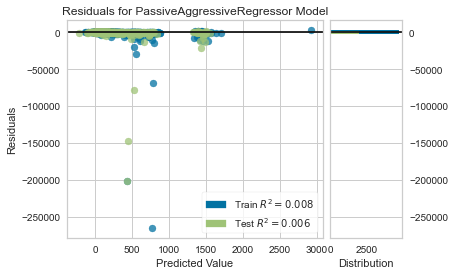

In [109]:
pycr.plot_model(tuned_modelo_a1)

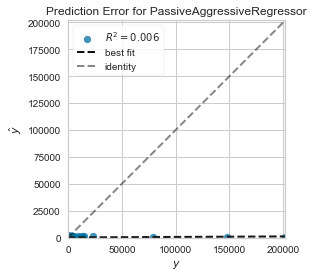

In [111]:
pycr.plot_model(tuned_modelo_a1, plot="error")

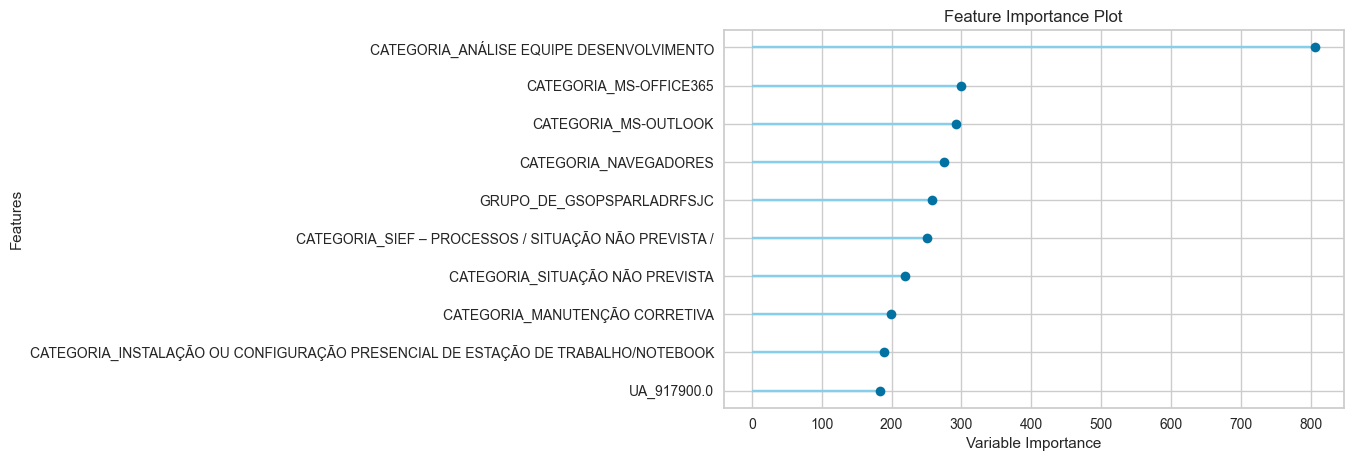

In [112]:
pycr.plot_model(tuned_modelo_a1, plot="feature")

In [113]:
pycr.predict_model(tuned_modelo_a1)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Passive Aggressive Regressor,348.9217,34550181.8680,5877.9403,0.0060,1.2742,3.6464


,TEMPO_PREVISTO_MINUTOS,QTDE_ENCAMINHA,HORA_ABERTURA,ACIONAMENTO_VIA_CHAMADA TELEFÔNICA,ACIONAMENTO_VIA_CHATBOT,ACIONAMENTO_VIA_Conversar com o agente.,ACIONAMENTO_VIA_E-MAIL,ACIONAMENTO_VIA_FAX,ACIONAMENTO_VIA_INTERNET,ACIONAMENTO_VIA_INTRANET,...,GRUPO_DE_NAO INFORMADO,DIA_DA_SEMANA_0,DIA_DA_SEMANA_1,DIA_DA_SEMANA_2,DIA_DA_SEMANA_3,DIA_DA_SEMANA_4,DIA_DA_SEMANA_5,DIA_DA_SEMANA_6,TEMPO_CONSUMIDO,Label
0,-0.352714,-0.336340,0.270748,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,42.072572
1,-0.352714,-0.336340,0.944106,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,41.0,100.132887
2,-0.352714,0.129957,0.270748,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,54.0,59.483926
3,-0.352714,-0.336340,0.607427,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,218.0,95.692009
4,0.236232,-0.336340,1.280785,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,52.0,24.591863
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2009,-0.352714,-0.336340,-0.739289,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,43.241550
2010,-0.352714,-0.336340,1.280785,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,78.0,32.118910
2011,-0.352714,-0.180908,1.954143,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,35.0,85.622646
2012,-0.352714,-0.180908,0.607427,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,107.0,89.446101


In [115]:
test_predict_a1 = pycr.predict_model(tuned_modelo_a1, data=pyc_chamados_a1_test)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Passive Aggressive Regressor,168.7736,4771779.4991,2184.4403,0.0141,1.2455,3.0192


In [116]:
percen_tempo_negativo = 100*len(test_predict_a1.loc[(test_predict_a1['Label']<0)])/len(test_predict_a1)
print("Percentual previsão com tempo negativo :", percen_tempo_negativo)

Percentual previsão com tempo negativo : 2.32419547079857


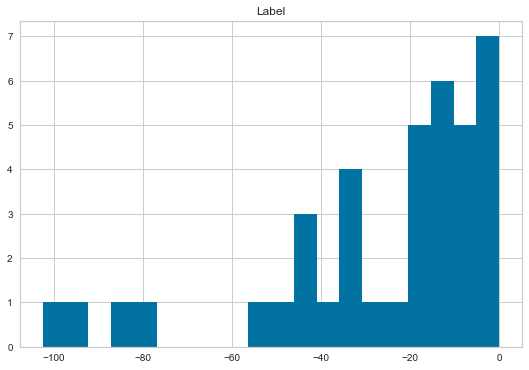

In [118]:
menor_zero = test_predict_a1.loc[(test_predict_a1['Label']<=0)] # retorna previsões menores que zero
menor_zero.hist(column='Label',    # Coluna a ser plotada
                   figsize=(9,6),   # Tamanho do gráfico
                   bins=20);         # Numero de colunas do histogram

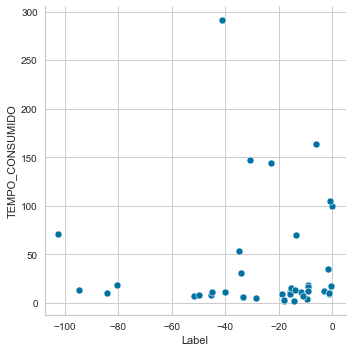

In [119]:
sns.relplot(x='Label', y='TEMPO_CONSUMIDO', data = menor_zero)

#### 4.2.5 - Resultados- Setup 2¶

##### Ajustes parâmetros, conforme observações
* Método Huber possui alto valor computacional
* Retirar os ```TEMPO_CONSUMIDO``` muito altos, como outliers.
*  Retirar os ```TEMPO_CONSUMIDO``` muito baixo, como anomalia.



#### 4.3.1 - Criação das bases de testes e treinamento - Setup 3

In [122]:
df_remove = df_completo.loc[(df_completo['TEMPO_PREVISTO_MINUTOS']>4320) 
                            |(df_completo['TEMPO_CONSUMIDO']>10000) # retiando altos tempos consumidos
                            | (df_completo['TEMPO_CONSUMIDO']<10)] # retirando chamados com tempo 0 e fechados em menos de 10 minutos 
#removendo chamados com tempo previsto = 0 ou maior  4320 minutos úteis (90% dos chamados tem tempo_previsto < 720 minutos) ou tempo_consumido > 10000 OU GRUPO_DE NÃO INFORMADO
df_remove.describe()

,TEMPO_CONSUMIDO,TEMPO_PREVISTO_MINUTOS,QTDE_ENCAMINHA,HORA_ABERTURA
count,2500.000000,2500.000000,2500.000000,2500.000000
mean,558.234000,430.500000,2.441200,12.458000
std,9002.276726,2857.313266,2.297271,3.323952
min,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,1.000000,10.000000
50%,0.000000,240.000000,2.000000,12.000000
75%,4.000000,240.000000,3.000000,15.000000
max,265940.000000,114880.000000,54.000000,23.000000


In [123]:
df_ajuste2 =  df_completo.drop(df_remove.index)

In [124]:
df_ajuste2.shape, df_completo.shape

((7342, 12), (9842, 12))

In [125]:
pyc_chamados_a2 = df_ajuste2

In [126]:
pyc_chamados_a2_train = pyc_chamados_a2.sample(frac=0.8, random_state=153) # cria a base de treinamento em 80% da original

In [127]:
pyc_chamados_a2_test = pyc_chamados_a2.drop(pyc_chamados_a2_train.index) # cria a base de teste em 20% da original

In [128]:
pyc_chamados_a2_train.shape , pyc_chamados_a2_test.shape

((5874, 12), (1468, 12))

In [129]:
pyc_chamados_a2_train.reset_index(drop=True, inplace=True)

In [130]:
pyc_chamados_a2_test.reset_index(drop=True, inplace=True)

#### 4.3.2 - Criação dos modelos - Setup 3

In [131]:
regpos_a2 = pycr.setup (data = pyc_chamados_a2_train,
               target = "TEMPO_CONSUMIDO",
               normalize = True, #incluindo normalização na base
                numeric_features = ['TEMPO_PREVISTO_MINUTOS'], #nesta simulação, incluido porque Pycaret está considerando categorico
               session_id= 456)

,Description,Value
0,session_id,456
1,Target,TEMPO_CONSUMIDO
2,Original Data,"(5874, 12)"
3,Missing Values,True
4,Numeric Features,3
5,Categorical Features,8
6,Ordinal Features,False
7,High Cardinality Features,False
8,High Cardinality Method,None
9,Transformed Train Set,"(4111, 648)"


In [132]:
best_a2 = pycr.compare_models(exclude = ["ransac"])

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
lasso,Lasso Regression,119.1682,166268.0766,400.6496,0.2892,1.0048,1.5896,0.0920
lightgbm,Light Gradient Boosting Machine,121.0058,170994.0182,404.2441,0.2822,1.0057,1.5225,0.1270
gbr,Gradient Boosting Regressor,115.9745,164508.3703,400.4313,0.2621,0.9652,1.5459,0.8240
huber,Huber Regressor,104.2608,175905.9044,411.3401,0.2595,0.8835,1.0027,2.5830
rf,Random Forest Regressor,106.8827,167501.2367,402.8957,0.2591,0.8509,1.0970,3.5060
llar,Lasso Least Angle Regression,128.1352,175622.3142,411.1732,0.2584,1.1343,2.1198,0.0670
ridge,Ridge Regression,136.3138,171623.6930,408.3541,0.2567,1.1649,1.8835,0.2970
br,Bayesian Ridge,136.4252,172039.7365,409.0208,0.2546,1.1634,1.8798,1.0550
par,Passive Aggressive Regressor,104.8311,178126.8502,413.9232,0.2511,0.9322,1.0013,0.3560
en,Elastic Net,124.7174,179856.1359,415.9454,0.2440,1.0897,2.0164,0.1460


In [133]:
modelo_a2 = pycr.create_model("lasso")

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,99.7062,152292.3906,390.2466,0.1164,1.0098,1.6486
1,121.7616,164051.2344,405.0324,0.3067,1.0153,1.6488
2,131.4097,137817.6406,371.2380,0.4056,0.9938,1.5649
3,108.7574,121780.5469,348.9707,0.3111,0.9977,1.5784
4,124.3850,276399.1875,525.7368,-0.0303,1.0042,1.5440
5,110.4004,91662.4844,302.7581,0.3416,0.9895,1.4903
6,127.1463,240549.2969,490.4583,0.2973,1.0323,1.5076
7,109.0322,78763.7031,280.6487,0.3542,0.9969,1.6551
8,122.7837,228300.1406,477.8076,0.3666,1.0005,1.6645


In [134]:
tuned_modelo_a2 = pycr.tune_model(modelo_a2)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,100.3436,152048.9375,389.9345,0.1178,1.0077,1.6824
1,122.8715,167071.9062,408.7443,0.2940,1.0023,1.6963
2,133.6944,141732.3438,376.4736,0.3887,0.9913,1.6228
3,105.8511,118459.4141,344.1793,0.3299,0.9797,1.5670
4,125.6045,275525.0312,524.9048,-0.0271,1.0005,1.5828
5,111.9937,91827.9531,303.0313,0.3405,0.9967,1.5500
6,128.6206,246065.2500,496.0497,0.2812,0.9874,1.5526
7,108.9926,79276.3516,281.5606,0.3500,0.9781,1.6958
8,124.1746,230947.9688,480.5705,0.3592,0.9873,1.7135


#### 4.3.4 - Resultados- Setup 3

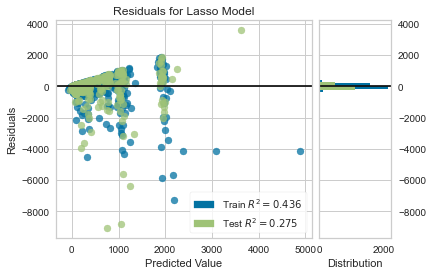

In [135]:
pycr.plot_model(modelo_a2)

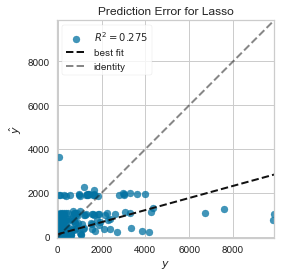

In [136]:
pycr.plot_model(modelo_a2, plot="error")

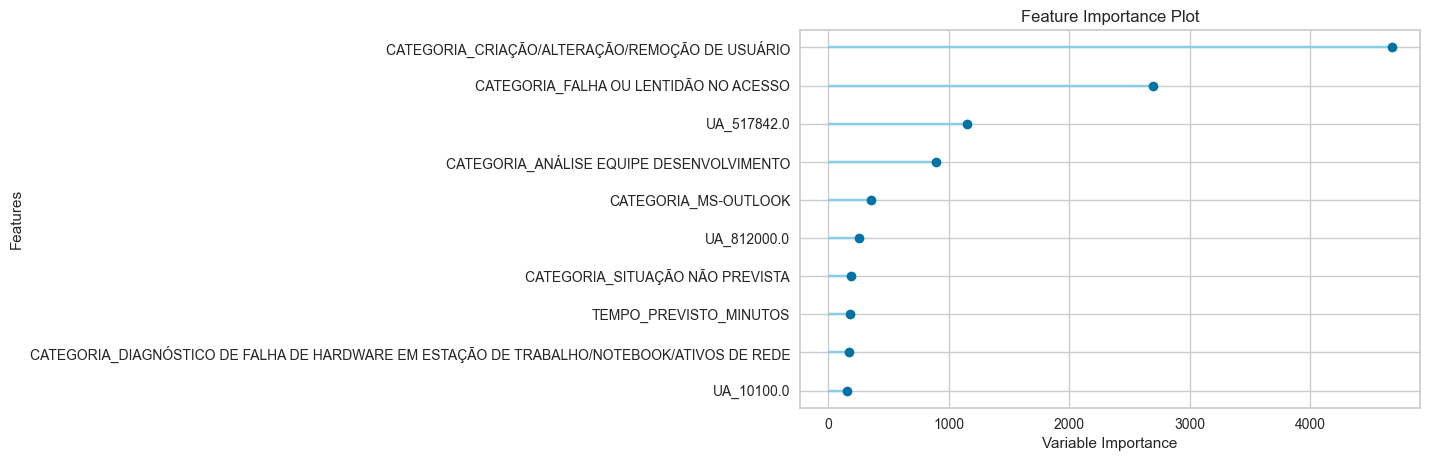

In [137]:
pycr.plot_model(modelo_a2, plot="feature")

In [138]:
pycr.predict_model(tuned_modelo_a2)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Lasso Regression,138.3252,236345.9062,486.1542,0.2775,1.0569,1.8351


,TEMPO_PREVISTO_MINUTOS,QTDE_ENCAMINHA,HORA_ABERTURA,ACIONAMENTO_VIA_Automático,ACIONAMENTO_VIA_CHAMADA TELEFÔNICA,ACIONAMENTO_VIA_CHATBOT,ACIONAMENTO_VIA_E-MAIL,ACIONAMENTO_VIA_INTERNET,ACIONAMENTO_VIA_INTRANET,ACIONAMENTO_VIA_SOLICORP RFB,...,GRUPO_DE_NAO INFORMADO,DIA_DA_SEMANA_0,DIA_DA_SEMANA_1,DIA_DA_SEMANA_2,DIA_DA_SEMANA_3,DIA_DA_SEMANA_4,DIA_DA_SEMANA_5,DIA_DA_SEMANA_6,TEMPO_CONSUMIDO,Label
0,-0.347945,-0.078602,1.635947,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,43.0,82.673607
1,-0.347945,0.138995,-0.402046,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,83.0,82.471313
2,-0.347945,-0.078602,-3.119371,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,13.0,74.424118
3,0.225410,-0.078602,-1.421043,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,51.0,64.782509
4,-0.347945,-0.731392,1.635947,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,11.0,54.233849
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1758,-0.347945,-0.513795,-0.402046,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,21.0,55.300140
1759,-0.347945,-0.513795,-1.081378,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,22.0,95.392868
1760,0.225410,-0.296198,-0.062381,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,93.0,80.179863
1761,-0.204606,-0.731392,-0.402046,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,111.0,83.496170


In [140]:
test_predict_a2 = pycr.predict_model(tuned_modelo_a2, data=pyc_chamados_a2_test)


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Lasso Regression,122.9440,172977.3888,415.9055,0.3247,0.9984,1.6172


In [141]:
percen_tempo_negativo = 100*len(test_predict_a2.loc[(test_predict_a2['Label']<0)])/len(test_predict_a2)
print("Percentual previsão com tempo negativo :", percen_tempo_negativo)


Percentual previsão com tempo negativo : 0.0


#### 4.3.5 - Análises e tentativas de melhoria - Setup 3
* Não houve a previsão de nenhum tempo negativo.
* A influência do grupo do primeiro atendimento diminuiu.
* A quantidade de pessoas que trabalha em um grupo pode influenciar no tempo que o chamado fica no grupo


#### 4.4.1 - Criação das bases de testes e treinamento -  Setup 4

In [142]:
# Busca na base de encaminhamento, quantos responsáveis diferentes atuaram nos chamados, para ter uma estimativa de quantas pessoas trabalham nos grupos

df_encaminha_resumo_pessoas = pd.read_sql ('SELECT B.NUMERO_TICKET, B.QTDE_ENCAMINHA, B.GRUPO_DE, B.QTDE_PESSOAS FROM CHAMADOS A LEFT JOIN (SELECT NUMERO_TICKET, COUNT(*) AS QTDE_ENCAMINHA, min(DTHORA_CONVERTIDA), GRUPO_DE, QTDE_PESSOAS FROM (SELECT A.NUMERO_TICKET, A.DTHORA_CONVERTIDA, A.GRUPO_DE, B.QTDE_PESSOAS FROM ( SELECT NUMERO_TICKET,  strftime("'"%Y-%m-%d %H:%M:%S"'",substr(DATA_HORA, 7,4)||"'"-"'"||substr(DATA_HORA, 4,2)||"'"-"'"||substr(DATA_HORA, 1,2)||"'" "'" ||substr(DATA_HORA, 12,8))  DTHORA_CONVERTIDA, GRUPO_DE FROM ENCAMINHAMENTOS WHERE GRUPO_DE IS NOT NULL) AS A  LEFT JOIN  (select grupo_de, count(distinct(RESPONSAVEL))as QTDE_PESSOAS from encaminhamentos where grupo_de is not null group by grupo_DE) b ON A.GRUPO_DE = B.GRUPO_DE WHERE B.GRUPO_DE IS NOT NULL ) GROUP BY NUMERO_TICKET) AS B ON A.NUMERO_TICKET = B.NUMERO_TICKET WHERE B.NUMERO_TICKET IS NOT NULL UNION SELECT a.NUMERO_TICKET, 0 as QTDE_ENCAMINHA, "'"NAO INFORMADO"'" AS GRUPO_DE, 0 as QTDE_PESSOAS FROM CHAMADOS A LEFT JOIN (SELECT NUMERO_TICKET, COUNT(*) AS QTDE_ENCAMINHA, min(DTHORA_CONVERTIDA), GRUPO_DE FROM (SELECT NUMERO_TICKET, strftime("'"%Y-%m-%d %H:%M:%S"'",substr(DATA_HORA, 7,4)||"'"-"'"||substr(DATA_HORA, 4,2)||"'"-"'"||substr(DATA_HORA, 1,2)||"'" "'" ||substr(DATA_HORA, 12,8)) DTHORA_CONVERTIDA, GRUPO_DE FROM ENCAMINHAMENTOS WHERE GRUPO_DE IS NOT NULL ) GROUP BY NUMERO_TICKET) AS B ON A.NUMERO_TICKET = B.NUMERO_TICKET WHERE B.NUMERO_TICKET IS NULL',con = conexaoBD)

In [143]:
df_encaminha_resumo_pessoas.head()

,NUMERO_TICKET,QTDE_ENCAMINHA,GRUPO_DE,QTDE_PESSOAS
0,2019SS/0000350741,10,ATGSSPRFB,34
1,2019SS/0000396318,16,ATGSSPRFB,34
2,2019SS/0000401230,12,ATGSSPRFB,34
3,2019SS/0000417381,17,ATGSSPRFB,34
4,2019SS/0000633518,7,ATGSSPRFB,34


In [144]:
#Junção dos Datasets Chamados (df_chamados) e Resumo de Encaminhamento de chamados (df_encaminha_resumo)
df_completo_novo = pd.merge(df_chamados, df_encaminha_resumo_pessoas, on='NUMERO_TICKET')
df_completo_novo.head()

,ACIONAMENTO,ACIONAMENTO_VIA,AGUARDANDO_USUARIO,ARF,CATEGORIA,CHAMADO_REABERTO,CLIENTE,CPF,CRIADO_POR,DATA_CONCLUIDO,...,UA,UF,UG_ATENDIMENTO,UG_SERVICO,UNIDADE,AGUARDANDOPRESTADOR,EMAIL,QTDE_ENCAMINHA,GRUPO_DE,QTDE_PESSOAS
0,2019SS/0000396318,INTERNET,Sim,None,NECESSIDADE DE GERAR DEMANDA,Não,RFB,69563187091.0,69563187091.0,25/04/2022 08:59:20,...,1017700.0,RS,SUNAC,SUNEF,ALF-PORTO DE RIO GRANDE,N,catia.sodre@receita.fazenda.gov.br,16,ATGSSPRFB,34
1,2022SS/0000242878,INTERNET,Sim,None,ATENDIMENTO REMOTO A ESTAÇÕES DE TRABALHO/NOTE...,Não,RFB,48464252072.0,28676497818.0,11/04/2022 09:49:07,...,1017700.0,RS,SUPOP,SUPOP,ALF-PORTO DE RIO GRANDE,N,alessandro.costa@receita.fazenda.gov.br,5,GSOPBRARLARF10SR,19
2,2022SS/0000243418,INTRANET,Não,None,MANUTENCAO DO SERVIDOR,Sim,SERPRO,94907285000.0,94907285000.0,11/04/2022 09:44:07,...,1017700.0,RS,SUPOP,SUPOP,ALF-PORTO DE RIO GRANDE,N,fabiano.gauterio@serpro.gov.br,5,GSOPDFARLRFBUCLR,12
3,2022SS/0000253561,INTERNET,Não,None,INSTALAÇÃO OU CONFIGURAÇÃO PRESENCIAL DE ESTAÇ...,Não,RFB,62038524068.0,62038524068.0,13/04/2022 11:29:10,...,1017700.0,None,SUPOP,SUPOP,ALF-PORTO DE RIO GRANDE,N,valesca.nunes@rfb.gov.br,11,GSOPRSARLAALFRGE,4
4,2022SS/0000255589,INTRANET,Não,None,ATENDIMENTO REMOTO A ESTAÇÕES DE TRABALHO/NOTE...,Não,SERPRO,55804993020.0,28676497818.0,13/04/2022 15:44:11,...,1017700.0,RS,SUPOP,SUPOP,ALF-PORTO DE RIO GRANDE,N,nory.s.ferreira@rfb.gov.br,2,GSOPBRARLARF10SR,19


In [145]:
df_completo_novo["DATA_EMISSAO"] = pd.to_datetime(df_chamados["DATA_EMISSAO"], dayfirst=True)
dia_da_semana= df_completo_novo["DATA_EMISSAO"].dt.dayofweek # identifica qual é o dia da semana de abertura do chamado 
# 0 = Segunda-feira e 6 = Domingo
df_completo_novo["DIA_DA_SEMANA"] = dia_da_semana   # Adiciona a coluna na base de dados.
hora_abertura= df_completo_novo["DATA_EMISSAO"].dt.hour # identifica qual é a hora de abertura do chamado 
df_completo_novo["HORA_ABERTURA"] = hora_abertura   # Adiciona a coluna na base de dados.

In [146]:
df_completo_novo.dropna(subset=['TEMPO_CONSUMIDO'], inplace=True)
df_completo_novo.dropna(subset=['UA'], inplace=True)
df_completo_novo.dropna(subset=['CATEGORIA'], inplace=True)
df_completo_novo.dropna(subset=['DATA_RESOLVIDO'], inplace=True)

In [147]:
df_completo_novo_copia = df_completo_novo.copy(deep=True)

In [148]:
del df_completo_novo["ACIONAMENTO"]
del df_completo_novo["AGUARDANDO_USUARIO"]
del df_completo_novo["CPF"]
del df_completo_novo["CRIADO_POR"]
del df_completo_novo["DESCRICAO_DEMANDA"]
del df_completo_novo["NOME"]
del df_completo_novo["OBSERVACAO"]
del df_completo_novo["SOLUCAO_APLICADA"]
del df_completo_novo["AGUARDANDOPRESTADOR"]
del df_completo_novo["EMAIL"]
del df_completo_novo["TIPO_TICKET_VINCULADO"]
del df_completo_novo["SUB_CATEGORIA"]
del df_completo_novo["TIPO_TICKET"]
del df_completo_novo["SITUACAO"]
del df_completo_novo["STATUS"]
del df_completo_novo["DESCRICAO_TKT_VINCULADO"]
del df_completo_novo["DATA_CONCLUIDO"]
del df_completo_novo["DATA_RESOLVIDO"]
del df_completo_novo["DATA_STATUS"]
del df_completo_novo["CHAMADO_REABERTO"]
del df_completo_novo["NUMERO_TICKET"]
del df_completo_novo["NR_TICKET_VINCULADO"]
del df_completo_novo["DATA_HORA_FIM_ATEND"]
del df_completo_novo["DATA_HORA_INICIO_ATEND"]
del df_completo_novo["RESPONSAVEL_PELO_ATENDIMENTO"]
del df_completo_novo["SETOR"]
del df_completo_novo["GRUPO_CRIACAO"]
del df_completo_novo["NIVEL_SEVERIDADE_INFRA"]
del df_completo_novo["GRUPO_GESTOR"]
del df_completo_novo["ARF"]
del df_completo_novo["MUNICIPIO_ATENDIMENTO"]
del df_completo_novo["OC_RF"]
del df_completo_novo["UF"]
del df_completo_novo["UNIDADE"]
del df_completo_novo["TIPO_RECURSO"]
del df_completo_novo["SERVICO"]
del df_completo_novo["UG_ATENDIMENTO"]
del df_completo_novo["UG_SERVICO"]
del df_completo_novo["TEMPO_DE_REACAO"]
del df_completo_novo["DATA_EMISSAO"] 

In [149]:
df_completo_novo["CATEGORIA"] = pd.Categorical(df_completo_novo["CATEGORIA"])
df_completo_novo["ACIONAMENTO_VIA"] = pd.Categorical(df_completo_novo["ACIONAMENTO_VIA"])
df_completo_novo["CLIENTE"] = pd.Categorical(df_completo_novo["CLIENTE"])
df_completo_novo["REDE_ASSISTIDA"] = pd.Categorical(df_completo_novo["REDE_ASSISTIDA"])
df_completo_novo["TIPO_USUARIO"] = pd.Categorical(df_completo_novo["TIPO_USUARIO"])
df_completo_novo["UA"] = pd.Categorical(df_completo_novo["UA"])
df_completo_novo["DIA_DA_SEMANA"] = pd.Categorical(df_completo_novo["DIA_DA_SEMANA"])
df_completo_novo["GRUPO_DE"] = pd.Categorical(df_completo_novo["GRUPO_DE"])

In [150]:
print("\nTipos dos dados de chamados:\n{0}\n".format(df_completo_novo.dtypes))


Tipos dos dados de chamados:
ACIONAMENTO_VIA           category
CATEGORIA                 category
CLIENTE                   category
REDE_ASSISTIDA            category
TEMPO_CONSUMIDO            float64
TEMPO_PREVISTO_MINUTOS       int64
TIPO_USUARIO              category
UA                        category
QTDE_ENCAMINHA               int64
GRUPO_DE                  category
QTDE_PESSOAS                 int64
DIA_DA_SEMANA             category
HORA_ABERTURA                int64
dtype: object



In [151]:
df_remove = df_completo_novo.loc[(df_completo_novo['TEMPO_PREVISTO_MINUTOS']>4320) 
                            |(df_completo_novo['TEMPO_CONSUMIDO']>10000) # retiando altos tempos consumidos
                            | (df_completo_novo['TEMPO_CONSUMIDO']<10)] # retirando chamados com tempo 0 e fechados em menos de 10 minutos 
#removendo chamados com tempo previsto = 0 ou maior  4320 minutos úteis (90% dos chamados tem tempo_previsto < 720 minutos) ou tempo_consumido > 10000 OU GRUPO_DE NÃO INFORMADO
df_remove.describe()

,TEMPO_CONSUMIDO,TEMPO_PREVISTO_MINUTOS,QTDE_ENCAMINHA,QTDE_PESSOAS,HORA_ABERTURA
count,2500.000000,2500.000000,2500.000000,2500.000000,2500.000000
mean,558.234000,430.500000,2.441200,16.142400,12.458000
std,9002.276726,2857.313266,2.297271,14.214997,3.323952
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,1.000000,4.000000,10.000000
50%,0.000000,240.000000,2.000000,7.000000,12.000000
75%,4.000000,240.000000,3.000000,30.000000,15.000000
max,265940.000000,114880.000000,54.000000,44.000000,23.000000


In [152]:
df_ajuste4 =  df_completo_novo.drop(df_remove.index)
df_ajuste4.shape, df_completo_novo.shape

((7342, 13), (9842, 13))

In [153]:
pyc_chamados_a4_train = df_ajuste4.sample(frac=0.8, random_state=153) # cria a base de treinamento em 80% da original
pyc_chamados_a4_test = df_ajuste4.drop(pyc_chamados_a4_train.index) # cria a base de teste em 20% da original

In [154]:
pyc_chamados_a4_train.shape , pyc_chamados_a4_test.shape

((5874, 13), (1468, 13))

In [155]:
pyc_chamados_a4_train.reset_index(drop=True, inplace=True)
pyc_chamados_a4_test.reset_index(drop=True, inplace=True)

#### 4.4.2 - Criação dos modelos - Setup 4

In [156]:
regpos_a4 = pycr.setup (data = pyc_chamados_a4_train,
               target = "TEMPO_CONSUMIDO",
               normalize = True, #incluindo normalização na base
                numeric_features = ['TEMPO_PREVISTO_MINUTOS'], #nesta simulação, incluido porque Pycaret está considerando categorico
               session_id= 457)

,Description,Value
0,session_id,457
1,Target,TEMPO_CONSUMIDO
2,Original Data,"(5874, 13)"
3,Missing Values,True
4,Numeric Features,4
5,Categorical Features,8
6,Ordinal Features,False
7,High Cardinality Features,False
8,High Cardinality Method,None
9,Transformed Train Set,"(4111, 637)"


In [157]:
best_a4 = pycr.compare_models(exclude = ["ransac"])

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
lasso,Lasso Regression,123.9905,152200.0727,375.5768,0.3236,1.0599,1.7006,0.0700
br,Bayesian Ridge,136.9246,153816.3520,379.3111,0.2996,1.1928,1.9292,1.0310
en,Elastic Net,127.1635,165964.7195,388.3638,0.2954,1.1038,2.0539,0.0610
llar,Lasso Least Angle Regression,130.6010,165659.1410,388.4127,0.2932,1.1472,2.1879,0.0550
par,Passive Aggressive Regressor,106.7808,169118.3892,391.4225,0.2842,0.9582,0.9965,0.1930
huber,Huber Regressor,105.9144,168580.2862,390.9888,0.2839,0.8920,0.9926,2.3350
lightgbm,Light Gradient Boosting Machine,122.7354,161654.8089,388.5804,0.2598,0.9798,1.5499,0.0760
ridge,Ridge Regression,146.2755,162490.3742,391.6779,0.2376,1.2234,2.1289,0.0610
rf,Random Forest Regressor,109.9726,162096.7245,386.0289,0.2327,0.8675,1.1221,3.7730
knn,K Neighbors Regressor,119.7705,164206.4336,391.2888,0.2268,0.9412,1.3792,0.4240


#### 4.4.3 - Escolha melhor modelo e Tunning - Setup 4¶

In [158]:
modelo_a4 = pycr.create_model("lasso")

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,142.7285,366400.7812,605.3105,0.3153,0.9641,1.5395
1,110.8266,140814.4844,375.2526,0.3066,1.1089,1.8672
2,120.8193,109813.3594,331.3810,0.2613,1.0884,1.6315
3,140.0428,163005.0938,403.7389,0.3145,1.1334,1.9008
4,156.8673,207823.7500,455.8769,0.3925,1.0923,1.7276
5,106.5005,52554.6719,229.2481,0.2491,1.1334,2.1172
6,118.4473,164573.7031,405.6768,0.3095,0.9840,1.5232
7,134.6087,159221.9688,399.0263,0.4186,1.0383,1.5444
8,87.8820,47765.2656,218.5527,0.3725,1.0151,1.5548


In [159]:
tuned_modelo_a4 = pycr.tune_model(modelo_a4)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,142.5807,366979.5000,605.7883,0.3142,0.9667,1.5244
1,110.8982,141445.6719,376.0927,0.3034,1.1393,1.8659
2,119.8797,109753.6328,331.2909,0.2617,1.1047,1.5817
3,138.1159,161612.3750,402.0104,0.3204,1.1173,1.8025
4,156.7542,208239.7812,456.3330,0.3913,1.0587,1.7207
5,106.9402,52402.8672,228.9167,0.2512,1.1428,2.0706
6,118.5435,163644.6719,404.5302,0.3134,1.0189,1.5238
7,133.6998,157624.6250,397.0197,0.4244,1.0001,1.4950
8,88.4122,48518.9062,220.2701,0.3626,1.0424,1.5235


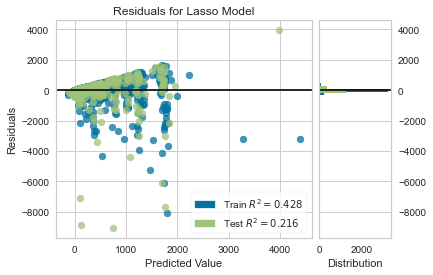

In [160]:
pycr.plot_model(tuned_modelo_a4)

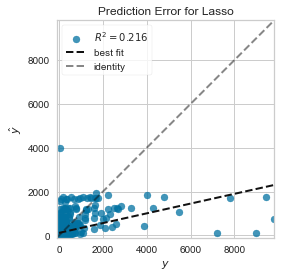

In [161]:
pycr.plot_model(tuned_modelo_a4, plot="error")

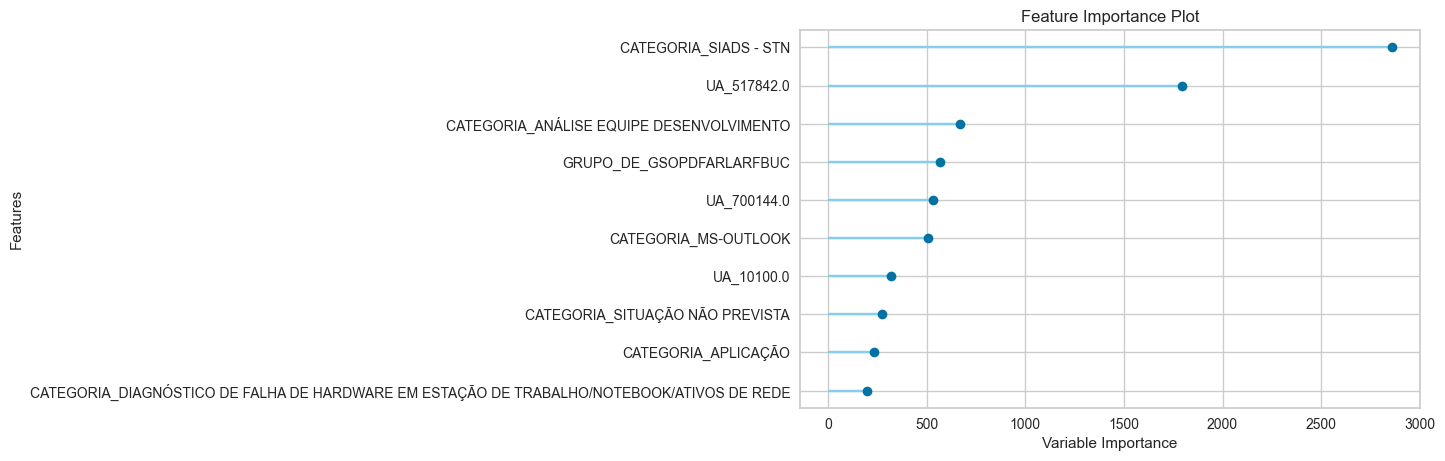

In [162]:
pycr.plot_model(tuned_modelo_a4, plot="feature")

In [163]:
pycr.predict_model(tuned_modelo_a4)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Lasso Regression,135.3079,267721.2812,517.4179,0.2157,1.1196,1.7988


,TEMPO_PREVISTO_MINUTOS,QTDE_ENCAMINHA,QTDE_PESSOAS,HORA_ABERTURA,ACIONAMENTO_VIA_CHAMADA TELEFÔNICA,ACIONAMENTO_VIA_CHATBOT,ACIONAMENTO_VIA_E-MAIL,ACIONAMENTO_VIA_FAX,ACIONAMENTO_VIA_INTERNET,ACIONAMENTO_VIA_INTRANET,...,GRUPO_DE_NAO INFORMADO,DIA_DA_SEMANA_0,DIA_DA_SEMANA_1,DIA_DA_SEMANA_2,DIA_DA_SEMANA_3,DIA_DA_SEMANA_4,DIA_DA_SEMANA_5,DIA_DA_SEMANA_6,TEMPO_CONSUMIDO,Label
0,-0.355004,-0.512140,-1.875956,0.276003,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,85.0,204.238846
1,-0.355004,-0.512140,1.122044,-0.399383,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,189.0,53.668785
2,-0.355004,0.158158,0.008501,-0.737076,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,19.0,14.521276
3,-0.355004,-0.065274,1.379015,-0.061690,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,324.0,68.677330
4,-0.355004,-0.065274,1.122044,-1.074769,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,66.0,81.726112
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1758,-0.355004,-0.959005,-2.389899,-1.074769,0.0,0.0,0.0,0.0,1.0,0.0,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,148.0,1.838623
1759,-0.355004,-0.512140,-1.790299,1.626776,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,154.0,53.167324
1760,-0.355004,-0.735573,1.122044,1.626776,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,58.0,17.666731
1761,2.841315,-0.288707,-2.047271,1.289083,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,737.0,539.735657


In [164]:
test_predict_a4 = pycr.predict_model(tuned_modelo_a4, data=pyc_chamados_a4_test)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Lasso Regression,126.0076,182195.2367,426.8433,0.2887,1.0535,1.6113


In [165]:
percen_tempo_negativo = 100*len(test_predict_a4.loc[(test_predict_a4['Label']<0)])/len(test_predict_a2)
print("Percentual previsão com tempo negativo :", percen_tempo_negativo)


Percentual previsão com tempo negativo : 2.3841961852861036


In [166]:
menor_zero = test_predict_a4.loc[(test_predict_a4['Label']<=0)] # retorna previsões menores que zero

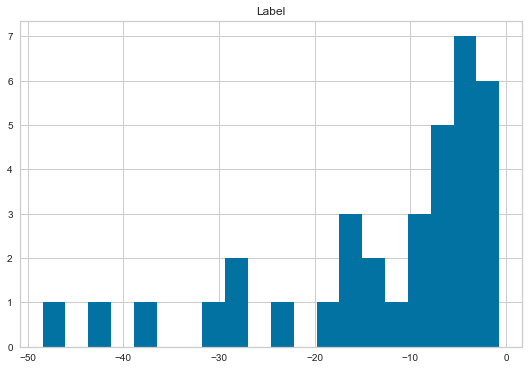

In [167]:
menor_zero.hist(column='Label',    # Coluna a ser plotada
                   figsize=(9,6),   # Tamanho do gráfico
                   bins=20);         # Numero de colunas do histogram

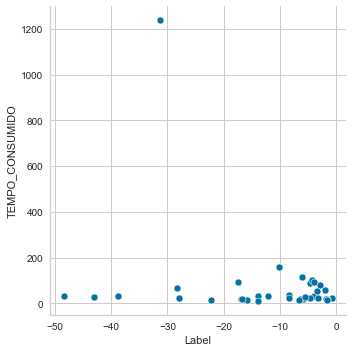

In [169]:
sns.relplot(x='Label', y='TEMPO_CONSUMIDO', data = menor_zero);

#### 4.4.5 - Análises e tentativas de melhoria - Setup 4

* O Modelo lasso melhorou um pouco com a adição da variável quantidade de pessoas, mas faz a previsão de tempos negativos¶
* Avaliar se há diferenças significativas de previsão do tempo de atendimento, considerando o tempo entre a abertura e o fechamento.



#### 4.5.1 - Criação das bases de testes e treinamento -  Setup 5

In [170]:
df_completo_novo_copia.dtypes

ACIONAMENTO                             object
ACIONAMENTO_VIA                         object
AGUARDANDO_USUARIO                      object
ARF                                     object
CATEGORIA                               object
CHAMADO_REABERTO                        object
CLIENTE                                 object
CPF                                     object
CRIADO_POR                              object
DATA_CONCLUIDO                          object
DATA_EMISSAO                    datetime64[ns]
DATA_HORA_FIM_ATEND                     object
DATA_HORA_INICIO_ATEND                  object
DATA_RESOLVIDO                          object
DATA_STATUS                             object
DESCRICAO_DEMANDA                       object
DESCRICAO_TKT_VINCULADO                 object
GRUPO_CRIACAO                           object
GRUPO_GESTOR                            object
MUNICIPIO_ATENDIMENTO                   object
NIVEL_SEVERIDADE_INFRA                  object
NOME         

In [171]:
df_completo_novo = df_completo_novo_copia.copy(deep=True)

In [172]:
# TRANSFORMA CAMPOS FORMATO DATA.
df_completo_novo["DATA_RESOLVIDO"] = pd.to_datetime(df_completo_novo["DATA_RESOLVIDO"], dayfirst=True) 
df_completo_novo["DATA_CONCLUIDO"] = pd.to_datetime(df_completo_novo["DATA_CONCLUIDO"], dayfirst=True)
df_completo_novo["DATA_STATUS"] = pd.to_datetime(df_completo_novo["DATA_STATUS"], dayfirst=True)

In [173]:
from sklearn.preprocessing import LabelEncoder #Transforma os campos Sim e Não em campos 0 e 1

cols = ['REDE_ASSISTIDA', 'CHAMADO_REABERTO', 'AGUARDANDO_USUARIO','AGUARDANDOPRESTADOR']  #unique pra descobrir quantos rótulos únicos
le = LabelEncoder()
df_completo_novo[cols] = df_completo_novo[cols].apply(le.fit_transform)

df_completo_novo.head(10)

,ACIONAMENTO,ACIONAMENTO_VIA,AGUARDANDO_USUARIO,ARF,CATEGORIA,CHAMADO_REABERTO,CLIENTE,CPF,CRIADO_POR,DATA_CONCLUIDO,...,UG_ATENDIMENTO,UG_SERVICO,UNIDADE,AGUARDANDOPRESTADOR,EMAIL,QTDE_ENCAMINHA,GRUPO_DE,QTDE_PESSOAS,DIA_DA_SEMANA,HORA_ABERTURA
0,2019SS/0000396318,INTERNET,1,None,NECESSIDADE DE GERAR DEMANDA,0,RFB,69563187091.0,69563187091.0,2022-04-25 08:59:20,...,SUNAC,SUNEF,ALF-PORTO DE RIO GRANDE,0,catia.sodre@receita.fazenda.gov.br,16,ATGSSPRFB,34,3,10
1,2022SS/0000242878,INTERNET,1,None,ATENDIMENTO REMOTO A ESTAÇÕES DE TRABALHO/NOTE...,0,RFB,48464252072.0,28676497818.0,2022-04-11 09:49:07,...,SUPOP,SUPOP,ALF-PORTO DE RIO GRANDE,0,alessandro.costa@receita.fazenda.gov.br,5,GSOPBRARLARF10SR,19,1,10
2,2022SS/0000243418,INTRANET,0,None,MANUTENCAO DO SERVIDOR,1,SERPRO,94907285000.0,94907285000.0,2022-04-11 09:44:07,...,SUPOP,SUPOP,ALF-PORTO DE RIO GRANDE,0,fabiano.gauterio@serpro.gov.br,5,GSOPDFARLRFBUCLR,12,1,11
3,2022SS/0000253561,INTERNET,0,None,INSTALAÇÃO OU CONFIGURAÇÃO PRESENCIAL DE ESTAÇ...,0,RFB,62038524068.0,62038524068.0,2022-04-13 11:29:10,...,SUPOP,SUPOP,ALF-PORTO DE RIO GRANDE,0,valesca.nunes@rfb.gov.br,11,GSOPRSARLAALFRGE,4,4,9
4,2022SS/0000255589,INTRANET,0,None,ATENDIMENTO REMOTO A ESTAÇÕES DE TRABALHO/NOTE...,0,SERPRO,55804993020.0,28676497818.0,2022-04-13 15:44:11,...,SUPOP,SUPOP,ALF-PORTO DE RIO GRANDE,0,nory.s.ferreira@rfb.gov.br,2,GSOPBRARLARF10SR,19,4,15
5,2022SS/0000255599,INTERNET,0,None,ATENDIMENTO REMOTO A ESTAÇÕES DE TRABALHO/NOTE...,0,RFB,69564000068.0,69564000068.0,2022-04-13 17:04:09,...,SUPOP,SUPOP,ALF-PORTO DE RIO GRANDE,0,carlos.frederico@rfb.gov.br,1,GSOPBRARLARF10SR,19,4,15
6,2022SS/0000255606,SOLICORP RFB,0,None,ATENDIMENTO REMOTO A ESTAÇÕES DE TRABALHO/NOTE...,0,RFB,62038524068.0,62038524068.0,2022-04-13 17:09:10,...,SUPOP,SUPOP,ALF-PORTO DE RIO GRANDE,0,valesca.nunes@rfb.gov.br,1,GSOPBRARLARF10SR,19,4,15
7,2022SS/0000255616,SOLICORP RFB,0,None,ATENDIMENTO REMOTO A ESTAÇÕES DE TRABALHO/NOTE...,0,RFB,62038524068.0,62038524068.0,2022-04-13 16:19:11,...,SUPOP,SUPOP,ALF-PORTO DE RIO GRANDE,0,valesca.nunes@rfb.gov.br,1,GSOPBRARLARF10SR,19,4,15
8,2022SS/0000255630,SOLICORP RFB,0,None,ATENDIMENTO REMOTO A ESTAÇÕES DE TRABALHO/NOTE...,0,RFB,62038524068.0,62038524068.0,2022-04-13 17:09:11,...,SUPOP,SUPOP,ALF-PORTO DE RIO GRANDE,0,valesca.nunes@rfb.gov.br,1,GSOPBRARLARF10SR,19,4,15
9,2022SS/0000255648,SOLICORP RFB,0,None,ATENDIMENTO REMOTO A ESTAÇÕES DE TRABALHO/NOTE...,0,RFB,62038524068.0,62038524068.0,2022-04-13 16:34:10,...,SUPOP,SUPOP,ALF-PORTO DE RIO GRANDE,0,valesca.nunes@rfb.gov.br,1,GSOPBRARLARF10SR,19,4,15


In [174]:
df_completo_novo.dtypes

ACIONAMENTO                             object
ACIONAMENTO_VIA                         object
AGUARDANDO_USUARIO                       int32
ARF                                     object
CATEGORIA                               object
CHAMADO_REABERTO                         int32
CLIENTE                                 object
CPF                                     object
CRIADO_POR                              object
DATA_CONCLUIDO                  datetime64[ns]
DATA_EMISSAO                    datetime64[ns]
DATA_HORA_FIM_ATEND                     object
DATA_HORA_INICIO_ATEND                  object
DATA_RESOLVIDO                  datetime64[ns]
DATA_STATUS                     datetime64[ns]
DESCRICAO_DEMANDA                       object
DESCRICAO_TKT_VINCULADO                 object
GRUPO_CRIACAO                           object
GRUPO_GESTOR                            object
MUNICIPIO_ATENDIMENTO                   object
NIVEL_SEVERIDADE_INFRA                  object
NOME         

In [175]:
del df_completo_novo["ACIONAMENTO"]
del df_completo_novo["CPF"]
del df_completo_novo["CRIADO_POR"]
del df_completo_novo["DESCRICAO_DEMANDA"]
del df_completo_novo["NOME"]
del df_completo_novo["OBSERVACAO"]
del df_completo_novo["SOLUCAO_APLICADA"]
del df_completo_novo["EMAIL"]
del df_completo_novo["TIPO_TICKET_VINCULADO"]
del df_completo_novo["SUB_CATEGORIA"]
del df_completo_novo["TIPO_TICKET"]
del df_completo_novo["SITUACAO"]
del df_completo_novo["STATUS"]
del df_completo_novo["DESCRICAO_TKT_VINCULADO"]
del df_completo_novo["DATA_CONCLUIDO"]
del df_completo_novo["DATA_RESOLVIDO"]
del df_completo_novo["DATA_STATUS"]
del df_completo_novo["NUMERO_TICKET"]
del df_completo_novo["NR_TICKET_VINCULADO"]
del df_completo_novo["DATA_HORA_FIM_ATEND"]
del df_completo_novo["DATA_HORA_INICIO_ATEND"]
del df_completo_novo["RESPONSAVEL_PELO_ATENDIMENTO"]
del df_completo_novo["SETOR"]
del df_completo_novo["GRUPO_CRIACAO"]
del df_completo_novo["NIVEL_SEVERIDADE_INFRA"]
del df_completo_novo["GRUPO_GESTOR"]
del df_completo_novo["ARF"]
del df_completo_novo["MUNICIPIO_ATENDIMENTO"]
del df_completo_novo["OC_RF"]
del df_completo_novo["UF"]
del df_completo_novo["UNIDADE"]
del df_completo_novo["TIPO_RECURSO"]
del df_completo_novo["UG_ATENDIMENTO"]
del df_completo_novo["UG_SERVICO"]
del df_completo_novo["TEMPO_DE_REACAO"]
del df_completo_novo["DATA_EMISSAO"] 
del df_completo_novo["SERVICO"]


#df_completo_novo["REDE_ASSISTIDA"] 
#del df_completo_novo["CHAMADO_REABERTO"]
#del df_completo_novo["AGUARDANDO_USUARIO"]
#del df_completo_novo["AGUARDANDOPRESTADOR"]

In [176]:
df_completo_novo["CATEGORIA"] = pd.Categorical(df_completo_novo["CATEGORIA"])
df_completo_novo["ACIONAMENTO_VIA"] = pd.Categorical(df_completo_novo["ACIONAMENTO_VIA"])
df_completo_novo["CLIENTE"] = pd.Categorical(df_completo_novo["CLIENTE"])
df_completo_novo["REDE_ASSISTIDA"] = pd.Categorical(df_completo_novo["REDE_ASSISTIDA"])
df_completo_novo["TIPO_USUARIO"] = pd.Categorical(df_completo_novo["TIPO_USUARIO"])
df_completo_novo["UA"] = pd.Categorical(df_completo_novo["UA"])
df_completo_novo["DIA_DA_SEMANA"] = pd.Categorical(df_completo_novo["DIA_DA_SEMANA"])
df_completo_novo["GRUPO_DE"] = pd.Categorical(df_completo_novo["GRUPO_DE"])
df_completo_novo["CHAMADO_REABERTO"] = pd.Categorical(df_completo_novo["CHAMADO_REABERTO"])
df_completo_novo["AGUARDANDO_USUARIO"] = pd.Categorical(df_completo_novo["AGUARDANDO_USUARIO"])
df_completo_novo["AGUARDANDOPRESTADOR"] = pd.Categorical(df_completo_novo["AGUARDANDOPRESTADOR"])


In [177]:
df_remove = df_completo_novo.loc[(df_completo_novo['TEMPO_PREVISTO_MINUTOS']>4320) 
                            |(df_completo_novo['TEMPO_CONSUMIDO']>10000) # retiando altos tempos consumidos
                            | (df_completo_novo['TEMPO_CONSUMIDO']<10)] # retirando chamados com tempo 0 e fechados em menos de 10 minutos 
#removendo chamados com tempo previsto = 0 ou maior  4320 minutos úteis (90% dos chamados tem tempo_previsto < 720 minutos) ou tempo_consumido > 10000 OU GRUPO_DE NÃO INFORMADO
df_remove.describe()

,TEMPO_CONSUMIDO,TEMPO_PREVISTO_MINUTOS,QTDE_ENCAMINHA,QTDE_PESSOAS,HORA_ABERTURA
count,2500.000000,2500.000000,2500.000000,2500.000000,2500.000000
mean,558.234000,430.500000,2.441200,16.142400,12.458000
std,9002.276726,2857.313266,2.297271,14.214997,3.323952
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,1.000000,4.000000,10.000000
50%,0.000000,240.000000,2.000000,7.000000,12.000000
75%,4.000000,240.000000,3.000000,30.000000,15.000000
max,265940.000000,114880.000000,54.000000,44.000000,23.000000


In [178]:
df_ajuste5 =  df_completo_novo.drop(df_remove.index)
df_ajuste5.shape, df_completo_novo.shape

((7342, 16), (9842, 16))

In [179]:
pyc_chamados_a5_train = df_ajuste5.sample(frac=0.8, random_state=153) # cria a base de treinamento em 80% da original
pyc_chamados_a5_test = df_ajuste5.drop(pyc_chamados_a5_train.index) # cria a base de teste em 20% da original

In [180]:
pyc_chamados_a5_train.shape , pyc_chamados_a5_test.shape

((5874, 16), (1468, 16))

In [181]:
pyc_chamados_a5_train.reset_index(drop=True, inplace=True)
pyc_chamados_a5_test.reset_index(drop=True, inplace=True)

In [182]:
df_completo_novo.isnull().sum() # Verifica quais variáveis tem valores nulos

ACIONAMENTO_VIA            0
AGUARDANDO_USUARIO         0
CATEGORIA                  0
CHAMADO_REABERTO           0
CLIENTE                   32
REDE_ASSISTIDA             0
TEMPO_CONSUMIDO            0
TEMPO_PREVISTO_MINUTOS     0
TIPO_USUARIO              20
UA                         0
AGUARDANDOPRESTADOR        0
QTDE_ENCAMINHA             0
GRUPO_DE                   0
QTDE_PESSOAS               0
DIA_DA_SEMANA              0
HORA_ABERTURA              0
dtype: int64

#### 4.5.2 - Criação dos modelos - Setup 5

In [183]:
regpos_a5 = pycr.setup (data = pyc_chamados_a5_train,
               target = "TEMPO_CONSUMIDO",
               normalize = True, #incluindo normalização na base
                numeric_features = ['TEMPO_PREVISTO_MINUTOS', 'REDE_ASSISTIDA', 'CHAMADO_REABERTO', 'AGUARDANDO_USUARIO','AGUARDANDOPRESTADOR'], #nesta simulação, incluido porque Pycaret está considerando categorico
               session_id= 458)

,Description,Value
0,session_id,458
1,Target,TEMPO_CONSUMIDO
2,Original Data,"(5874, 16)"
3,Missing Values,True
4,Numeric Features,8
5,Categorical Features,7
6,Ordinal Features,False
7,High Cardinality Features,False
8,High Cardinality Method,None
9,Transformed Train Set,"(4111, 648)"


In [184]:
best_a5 = pycr.compare_models(exclude = ["ransac"])

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
lasso,Lasso Regression,122.5421,176359.3984,402.1259,0.3443,0.9918,1.5997,0.0640
huber,Huber Regressor,108.1800,184629.9407,411.0358,0.3201,0.8925,1.0286,2.5550
llar,Lasso Least Angle Regression,131.2521,184561.6526,411.8315,0.3154,1.1477,2.1688,0.1030
par,Passive Aggressive Regressor,108.5363,188117.5439,415.3636,0.3057,0.9385,0.9667,0.1560
lightgbm,Light Gradient Boosting Machine,125.6732,178878.5203,407.9670,0.3051,1.0312,1.6296,0.0830
en,Elastic Net,129.2719,191379.7645,420.1207,0.2870,1.1022,2.0539,0.0430
ridge,Ridge Regression,142.6133,190887.0750,419.6065,0.2778,1.2069,1.9842,0.0670
br,Bayesian Ridge,143.1025,194452.0090,423.1598,0.2670,1.1950,1.9807,0.8930
knn,K Neighbors Regressor,121.2962,186665.1789,421.6793,0.2480,0.9389,1.3793,0.5320
omp,Orthogonal Matching Pursuit,131.0194,208779.1482,433.7787,0.2430,0.9977,1.6029,0.0690


#### 4.5.3 - Escolha melhor modelo e Tunning - Setup 5



In [185]:
modelo_a5 = pycr.create_model("lasso") 


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,103.0154,69268.1641,263.1884,0.4349,1.0072,1.8267
1,101.6480,63160.8281,251.3182,0.3303,0.9778,1.5917
2,103.0991,81762.3906,285.9412,0.5804,0.9641,1.5813
3,156.7979,273759.0312,523.2198,0.2781,1.0600,1.7931
4,119.1342,227473.8438,476.9422,0.3187,0.9570,1.4851
5,113.4416,91508.3203,302.5034,0.3594,0.9621,1.4499
6,121.7578,111194.5781,333.4585,0.4410,1.0009,1.6056
7,131.3485,262367.1562,512.2179,0.2795,1.0324,1.6438
8,148.5809,223700.8281,472.9702,0.2368,0.9951,1.6081


In [186]:
tuned_modelo_a5 = pycr.tune_model(modelo_a5)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,102.2248,70115.7266,264.7937,0.4280,1.0194,1.9117
1,100.7270,60504.4531,245.9765,0.3585,0.9898,1.6538
2,109.2739,88262.0703,297.0893,0.5471,0.9870,1.6948
3,155.7323,262925.9062,512.7630,0.3067,1.0654,1.8369
4,121.0069,231704.3906,481.3568,0.3060,0.9697,1.5625
5,115.9168,92278.6484,303.7740,0.3540,0.9720,1.5401
6,122.7619,111580.0469,334.0360,0.4391,1.0157,1.7315
7,133.3806,268341.1250,518.0165,0.2631,1.0293,1.6631
8,149.7938,219442.2188,468.4466,0.2513,1.0214,1.6967


#### 4.5.4 - Resultados- Setup 5

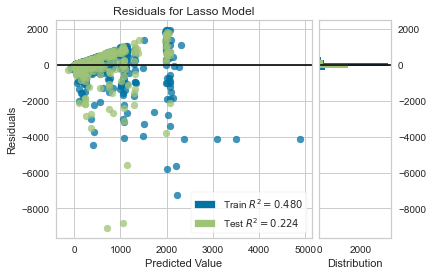

In [187]:
pycr.plot_model(modelo_a5)

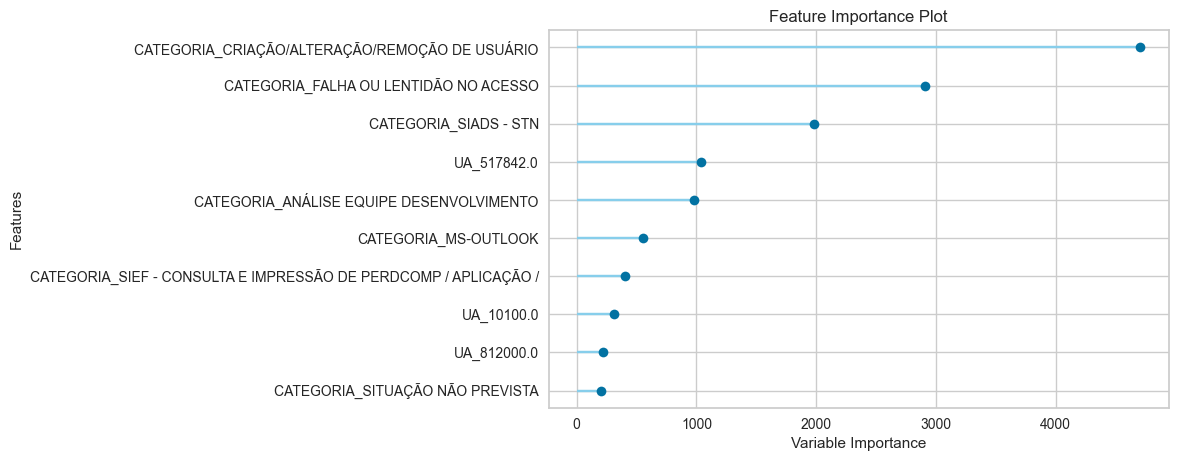

In [188]:
pycr.plot_model(modelo_a5, plot="feature")

In [189]:
pycr.predict_model(tuned_modelo_a5)


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Lasso Regression,128.5906,213811.7656,462.3978,0.2274,0.9994,1.6948


,AGUARDANDO_USUARIO,CHAMADO_REABERTO,REDE_ASSISTIDA,TEMPO_PREVISTO_MINUTOS,AGUARDANDOPRESTADOR,QTDE_ENCAMINHA,QTDE_PESSOAS,HORA_ABERTURA,ACIONAMENTO_VIA_Automático,ACIONAMENTO_VIA_CHAMADA TELEFÔNICA,...,GRUPO_DE_NAO INFORMADO,DIA_DA_SEMANA_0,DIA_DA_SEMANA_1,DIA_DA_SEMANA_2,DIA_DA_SEMANA_3,DIA_DA_SEMANA_4,DIA_DA_SEMANA_5,DIA_DA_SEMANA_6,TEMPO_CONSUMIDO,Label
0,2.166542,-0.125754,0.344441,-0.352564,-0.022062,0.375122,1.115865,1.984428,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,41.0,139.038391
1,-0.461565,-0.125754,0.344441,0.206067,-0.022062,-0.354637,-1.878750,0.961953,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,65.0,46.803112
2,2.166542,-0.125754,0.344441,-0.352564,-0.022062,1.250832,-0.424222,-1.082995,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,222.0,137.900024
3,-0.461565,-0.125754,0.344441,-0.352564,-0.022062,-0.208685,-0.253102,1.643603,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,28.0,62.709770
4,-0.461565,-0.125754,0.344441,-0.352564,-0.022062,-0.208685,1.372547,-0.742171,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,16.0,52.526688
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1758,-0.461565,-0.125754,0.344441,-0.352564,-0.022062,-0.354637,-0.766464,0.961953,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,30.0,53.604988
1759,-0.461565,-0.125754,0.344441,0.206067,-0.022062,0.083218,0.003580,1.643603,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,40.0,129.147583
1760,-0.461565,-0.125754,0.344441,-0.073249,-0.022062,-0.208685,-2.135431,-0.742171,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,113.0,-8.748039
1761,-0.461565,-0.125754,0.344441,0.764698,-0.022062,1.396784,-2.220992,-0.742171,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,110.0,308.803955


In [190]:
test_predict_a5 = pycr.predict_model(tuned_modelo_a5, data=pyc_chamados_a5_test)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Lasso Regression,122.3864,178120.3471,422.0431,0.3046,0.9746,1.5408


In [191]:
percen_tempo_negativo = 100*len(test_predict_a5.loc[(test_predict_a5['Label']<0)])/len(test_predict_a5)
print("Percentual previsão com tempo negativo :", percen_tempo_negativo)

Percentual previsão com tempo negativo : 0.20435967302452315


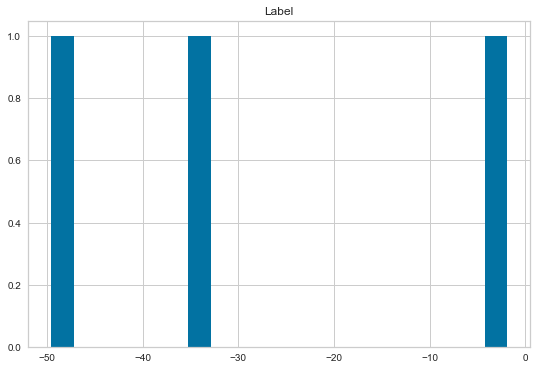

In [192]:
menor_zero = test_predict_a5.loc[(test_predict_a5['Label']<=0)] # retorna previsões menores que zero
menor_zero.hist(column='Label',    # Coluna a ser plotada
                   figsize=(9,6),   # Tamanho do gráfico
                   bins=20);         # Numero de colunas do histogram

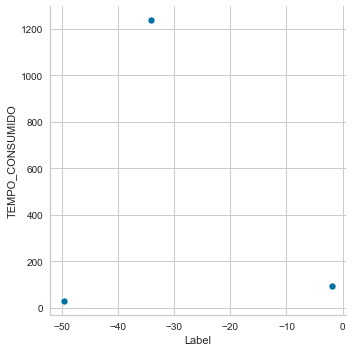

In [189]:
sns.relplot(x='Label', y='TEMPO_CONSUMIDO', data = menor_zero);

#### 4.6.1 - Criação das bases de testes e treinamento -  Setup 6

In [249]:
df_completo_novo = df_completo_novo_copia.copy(deep=True)


In [250]:
from sklearn.preprocessing import LabelEncoder #Transforma os campos Sim e Não em campos 0 e 1

cols = ['REDE_ASSISTIDA', 'CHAMADO_REABERTO', 'AGUARDANDO_USUARIO','AGUARDANDOPRESTADOR']  #unique pra descobrir quantos rótulos únicos
le = LabelEncoder()
df_completo_novo[cols] = df_completo_novo[cols].apply(le.fit_transform)

df_completo_novo.head()

,ACIONAMENTO,ACIONAMENTO_VIA,AGUARDANDO_USUARIO,ARF,CATEGORIA,CHAMADO_REABERTO,CLIENTE,CPF,CRIADO_POR,DATA_CONCLUIDO,...,UG_ATENDIMENTO,UG_SERVICO,UNIDADE,AGUARDANDOPRESTADOR,EMAIL,QTDE_ENCAMINHA,GRUPO_DE,QTDE_PESSOAS,DIA_DA_SEMANA,HORA_ABERTURA
0,2019SS/0000396318,INTERNET,1,None,NECESSIDADE DE GERAR DEMANDA,0,RFB,69563187091.0,69563187091.0,25/04/2022 08:59:20,...,SUNAC,SUNEF,ALF-PORTO DE RIO GRANDE,0,catia.sodre@receita.fazenda.gov.br,16,ATGSSPRFB,34,3,10
1,2022SS/0000242878,INTERNET,1,None,ATENDIMENTO REMOTO A ESTAÇÕES DE TRABALHO/NOTE...,0,RFB,48464252072.0,28676497818.0,11/04/2022 09:49:07,...,SUPOP,SUPOP,ALF-PORTO DE RIO GRANDE,0,alessandro.costa@receita.fazenda.gov.br,5,GSOPBRARLARF10SR,19,1,10
2,2022SS/0000243418,INTRANET,0,None,MANUTENCAO DO SERVIDOR,1,SERPRO,94907285000.0,94907285000.0,11/04/2022 09:44:07,...,SUPOP,SUPOP,ALF-PORTO DE RIO GRANDE,0,fabiano.gauterio@serpro.gov.br,5,GSOPDFARLRFBUCLR,12,1,11
3,2022SS/0000253561,INTERNET,0,None,INSTALAÇÃO OU CONFIGURAÇÃO PRESENCIAL DE ESTAÇ...,0,RFB,62038524068.0,62038524068.0,13/04/2022 11:29:10,...,SUPOP,SUPOP,ALF-PORTO DE RIO GRANDE,0,valesca.nunes@rfb.gov.br,11,GSOPRSARLAALFRGE,4,4,9
4,2022SS/0000255589,INTRANET,0,None,ATENDIMENTO REMOTO A ESTAÇÕES DE TRABALHO/NOTE...,0,SERPRO,55804993020.0,28676497818.0,13/04/2022 15:44:11,...,SUPOP,SUPOP,ALF-PORTO DE RIO GRANDE,0,nory.s.ferreira@rfb.gov.br,2,GSOPBRARLARF10SR,19,4,15


In [251]:
del df_completo_novo["ACIONAMENTO"]
del df_completo_novo["CPF"]
del df_completo_novo["CRIADO_POR"]
del df_completo_novo["DESCRICAO_DEMANDA"]
del df_completo_novo["NOME"]
del df_completo_novo["OBSERVACAO"]
del df_completo_novo["SOLUCAO_APLICADA"]
del df_completo_novo["EMAIL"]
del df_completo_novo["TIPO_TICKET_VINCULADO"]
del df_completo_novo["SUB_CATEGORIA"]
del df_completo_novo["TIPO_TICKET"]
del df_completo_novo["SITUACAO"]
del df_completo_novo["STATUS"]
del df_completo_novo["DESCRICAO_TKT_VINCULADO"]
del df_completo_novo["DATA_CONCLUIDO"]
del df_completo_novo["DATA_RESOLVIDO"]
del df_completo_novo["DATA_STATUS"]
del df_completo_novo["NUMERO_TICKET"]
del df_completo_novo["NR_TICKET_VINCULADO"]
del df_completo_novo["DATA_HORA_FIM_ATEND"]
del df_completo_novo["DATA_HORA_INICIO_ATEND"]
del df_completo_novo["RESPONSAVEL_PELO_ATENDIMENTO"]
del df_completo_novo["SETOR"]
del df_completo_novo["GRUPO_CRIACAO"]
del df_completo_novo["NIVEL_SEVERIDADE_INFRA"]
del df_completo_novo["GRUPO_GESTOR"]
del df_completo_novo["ARF"]
del df_completo_novo["MUNICIPIO_ATENDIMENTO"]
del df_completo_novo["OC_RF"]
del df_completo_novo["UF"]
del df_completo_novo["UNIDADE"]
del df_completo_novo["TIPO_RECURSO"]
del df_completo_novo["UG_ATENDIMENTO"]
del df_completo_novo["UG_SERVICO"]
del df_completo_novo["TEMPO_DE_REACAO"]
del df_completo_novo["DATA_EMISSAO"] 
del df_completo_novo["SERVICO"]
del df_completo_novo["GRUPO_DE"]
del df_completo_novo["UA"]



In [252]:
df_completo_novo["CATEGORIA"] = pd.Categorical(df_completo_novo["CATEGORIA"])
df_completo_novo["ACIONAMENTO_VIA"] = pd.Categorical(df_completo_novo["ACIONAMENTO_VIA"])
df_completo_novo["CLIENTE"] = pd.Categorical(df_completo_novo["CLIENTE"])
df_completo_novo["REDE_ASSISTIDA"] = pd.Categorical(df_completo_novo["REDE_ASSISTIDA"])
df_completo_novo["TIPO_USUARIO"] = pd.Categorical(df_completo_novo["TIPO_USUARIO"])
df_completo_novo["DIA_DA_SEMANA"] = pd.Categorical(df_completo_novo["DIA_DA_SEMANA"])
df_completo_novo["CHAMADO_REABERTO"] = pd.Categorical(df_completo_novo["CHAMADO_REABERTO"])
df_completo_novo["AGUARDANDO_USUARIO"] = pd.Categorical(df_completo_novo["AGUARDANDO_USUARIO"])
df_completo_novo["AGUARDANDOPRESTADOR"] = pd.Categorical(df_completo_novo["AGUARDANDOPRESTADOR"])

In [253]:
df_remove = df_completo_novo.loc[(df_completo_novo['TEMPO_PREVISTO_MINUTOS']>4320) 
                            |(df_completo_novo['TEMPO_CONSUMIDO']>10000) # retiando altos tempos consumidos
                            | (df_completo_novo['TEMPO_CONSUMIDO']<10)] # retirando chamados com tempo 0 e fechados em menos de 10 minutos 
#removendo chamados com tempo previsto = 0 ou maior  4320 minutos úteis (90% dos chamados tem tempo_previsto < 720 minutos) ou tempo_consumido > 10000 OU GRUPO_DE NÃO INFORMADO
df_remove.describe()

,TEMPO_CONSUMIDO,TEMPO_PREVISTO_MINUTOS,QTDE_ENCAMINHA,QTDE_PESSOAS,HORA_ABERTURA
count,2500.000000,2500.000000,2500.000000,2500.000000,2500.000000
mean,558.234000,430.500000,2.441200,16.142400,12.458000
std,9002.276726,2857.313266,2.297271,14.214997,3.323952
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,1.000000,4.000000,10.000000
50%,0.000000,240.000000,2.000000,7.000000,12.000000
75%,4.000000,240.000000,3.000000,30.000000,15.000000
max,265940.000000,114880.000000,54.000000,44.000000,23.000000


In [254]:
df_ajuste6 =  df_completo_novo.drop(df_remove.index)
df_ajuste6.shape, df_completo_novo.shape

((7342, 14), (9842, 14))

In [255]:
pyc_chamados_a6_train = df_ajuste6.sample(frac=0.8, random_state=153) # cria a base de treinamento em 80% da original
pyc_chamados_a6_test = df_ajuste6.drop(pyc_chamados_a6_train.index) # cria a base de teste em 20% da original

In [256]:
pyc_chamados_a6_train.shape , pyc_chamados_a6_test.shape

((5874, 14), (1468, 14))

In [257]:
pyc_chamados_a6_train.reset_index(drop=True, inplace=True)
pyc_chamados_a6_test.reset_index(drop=True, inplace=True)

#### 4.6.2 - Criação dos modelos - Setup 6

In [280]:
regpos_a6 = pycr.setup (data = pyc_chamados_a6_train,
               target = "TEMPO_CONSUMIDO",
               normalize = True, #incluindo normalização na base
               numeric_features = ['TEMPO_PREVISTO_MINUTOS'],
                remove_outliers = True, 
                 outliers_threshold = 0.02,
                     session_id= 458)

,Description,Value
0,session_id,458
1,Target,TEMPO_CONSUMIDO
2,Original Data,"(5874, 14)"
3,Missing Values,True
4,Numeric Features,4
5,Categorical Features,9
6,Ordinal Features,False
7,High Cardinality Features,False
8,High Cardinality Method,None
9,Transformed Train Set,"(4028, 100)"


In [281]:
best_a6 = pycr.compare_models(exclude = ["ransac"])

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
ridge,Ridge Regression,110.5847,129520.0648,346.7174,0.4006,0.9970,1.4113,0.0220
lasso,Lasso Regression,110.0663,129532.0766,347.2377,0.3999,0.9748,1.4335,0.0350
br,Bayesian Ridge,110.8153,131177.1204,348.6042,0.3945,0.9932,1.4075,0.0550
omp,Orthogonal Matching Pursuit,110.1942,136952.7290,355.9611,0.3713,0.9460,1.4310,0.0230
huber,Huber Regressor,96.0822,138676.1555,358.8801,0.3630,0.8369,0.9106,0.4070
llar,Lasso Least Angle Regression,119.8648,140265.1430,361.5434,0.3527,1.1139,2.0253,0.8420
par,Passive Aggressive Regressor,97.4256,142979.4712,364.6111,0.3446,0.8764,0.9592,0.0410
gbr,Gradient Boosting Regressor,107.0005,140758.6479,362.0255,0.3432,0.9191,1.3711,0.1840
knn,K Neighbors Regressor,108.0095,138353.1527,362.2217,0.3329,0.9123,1.2218,0.0730
en,Elastic Net,117.5065,147088.7926,370.6849,0.3208,1.0735,1.9055,0.0240


#### 4.6.3 - Escolha melhor modelo e Tunning - Setup 6¶

In [282]:
modelo_a6 = pycr.create_model("ridge")

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,98.4614,66456.7891,257.7921,0.4588,1.0091,1.5255
1,89.2001,52881.7188,229.9603,0.3980,0.9275,1.2567
2,96.3060,73957.3828,271.9511,0.6255,0.9412,1.3861
3,141.7392,237187.4375,487.0189,0.3384,1.0471,1.5506
4,115.7117,229979.7656,479.5620,0.2980,1.0300,1.4588
5,108.2746,93050.4219,305.0417,0.3540,1.0534,1.3090
6,108.7285,100760.7812,317.4284,0.4964,1.0159,1.4515
7,115.7356,146686.1406,382.9963,0.4049,1.0104,1.4994
8,148.3259,227373.7656,476.8372,0.2390,1.0022,1.4859


In [283]:
tuned_modelo_a6 = pycr.tune_model(modelo_a6)


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,99.5041,67138.2969,259.1106,0.4533,1.0024,1.5534
1,88.9221,51025.5547,225.8884,0.4191,0.9431,1.2436
2,99.5730,78023.5938,279.3270,0.6049,0.9333,1.4194
3,137.8408,230100.8906,479.6883,0.3581,1.0133,1.5531
4,117.3290,231323.6562,480.9612,0.2939,1.0520,1.5108
5,109.8535,94067.2891,306.7039,0.3470,1.0639,1.3085
6,109.7178,101915.4922,319.2421,0.4906,0.9940,1.4340
7,112.8033,139422.5938,373.3933,0.4343,1.0006,1.4594
8,145.6655,219139.5000,468.1234,0.2666,1.0149,1.4731


#### 4.6.4 - Resultados- Setup 6¶

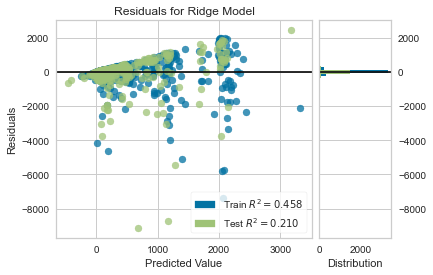

In [284]:
pycr.plot_model(modelo_a6)

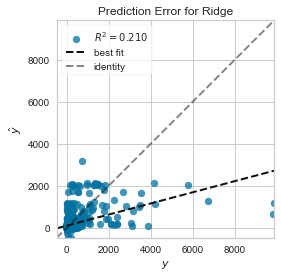

In [285]:
pycr.plot_model(modelo_a6, plot="error")

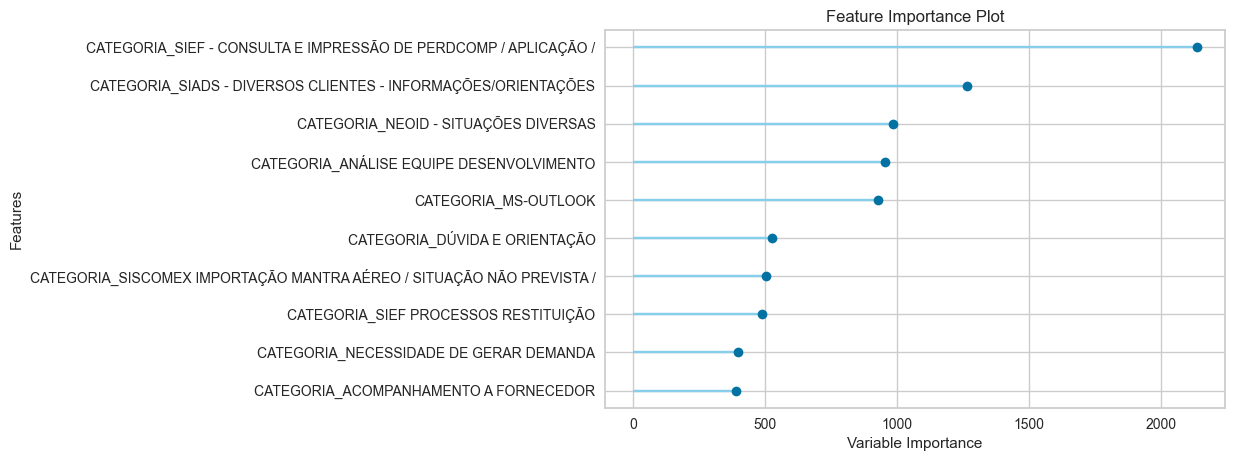

In [286]:
pycr.plot_model(modelo_a6, plot="feature")

In [287]:
pycr.predict_model(modelo_a6)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Ridge Regression,130.3550,218596.9219,467.5435,0.2101,1.0468,1.5524


,TEMPO_PREVISTO_MINUTOS,QTDE_ENCAMINHA,QTDE_PESSOAS,HORA_ABERTURA,ACIONAMENTO_VIA_CHAMADA TELEFÔNICA,ACIONAMENTO_VIA_E-MAIL,ACIONAMENTO_VIA_INTERNET,ACIONAMENTO_VIA_INTRANET,ACIONAMENTO_VIA_SOLICORP RFB,ACIONAMENTO_VIA_URA,...,AGUARDANDOPRESTADOR_0,DIA_DA_SEMANA_0,DIA_DA_SEMANA_1,DIA_DA_SEMANA_2,DIA_DA_SEMANA_3,DIA_DA_SEMANA_4,DIA_DA_SEMANA_5,DIA_DA_SEMANA_6,TEMPO_CONSUMIDO,Label
0,-0.352564,0.375122,1.115865,1.984428,0.0,0.0,1.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,41.0,190.754852
1,0.206067,-0.354637,-1.878750,0.961953,0.0,0.0,0.0,1.0,0.0,0.0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,65.0,6.128315
2,-0.352564,1.250832,-0.424222,-1.082995,0.0,0.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,222.0,257.638214
3,-0.352564,-0.208685,-0.253102,1.643603,0.0,0.0,0.0,0.0,1.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,28.0,78.393280
4,-0.352564,-0.208685,1.372547,-0.742171,0.0,0.0,1.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,16.0,45.794552
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1758,-0.352564,-0.354637,-0.766464,0.961953,0.0,0.0,0.0,0.0,1.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,30.0,48.456360
1759,0.206067,0.083218,0.003580,1.643603,0.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,40.0,185.217682
1760,-0.073249,-0.208685,-2.135431,-0.742171,0.0,0.0,0.0,1.0,0.0,0.0,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,113.0,-38.739113
1761,0.764698,1.396784,-2.220992,-0.742171,0.0,0.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,110.0,225.368439


In [288]:
test_predict_a6 = pycr.predict_model(tuned_modelo_a6, data=pyc_chamados_a6_test)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Ridge Regression,120.7416,179252.2190,423.3819,0.3002,0.9805,1.3530


In [289]:
percen_tempo_negativo = 100*len(test_predict_a6.loc[(test_predict_a6['Label']<0)])/len(test_predict_a6)
print("Percentual previsão com tempo negativo :", percen_tempo_negativo)

Percentual previsão com tempo negativo : 1.8392370572207084


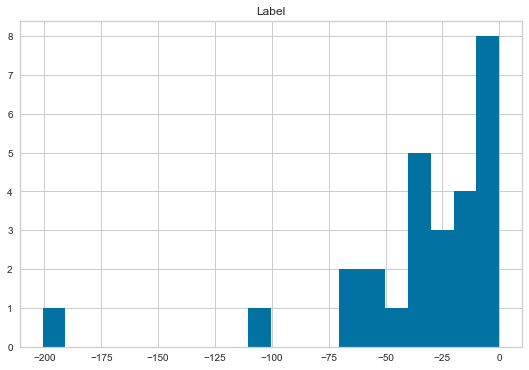

In [290]:
menor_zero = test_predict_a6.loc[(test_predict_a6['Label']<=0)] # retorna previsões menores que zero
menor_zero.hist(column='Label',    # Coluna a ser plotada
                   figsize=(9,6),   # Tamanho do gráfico
                   bins=20);         # Numero de colunas do histogram

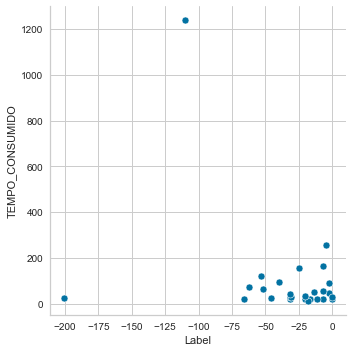

In [291]:
sns.relplot(x='Label', y='TEMPO_CONSUMIDO', data = menor_zero);